In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, BatchNormalization
from tensorflow.keras.utils import Progbar
import tensorflow.keras.backend as K

from sklearn.mixture import GaussianMixture

import numpy as np
import pandas as pd
import math
import umap

import matplotlib.pyplot as plt
%matplotlib inline  

TensorFlow 2.x selected.


# Loading Data

In [0]:
from google.colab import drive
drive.mount('/content/drive')
!pip install rpy2
import rpy2.robjects as robjects
file_name = 'neonatal-rib-cartilage_mca'
#'dentate-gyrus-neurogenesis_hochgerner'
#'b_cd14_cd56'
robjects.r['load']("/content/drive/My Drive/Data/%s.RData"%file_name)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f88852d6b88 / R:0xaa50c48>
['.Random.seed', 'neonatal-rib-cartilage...]

In [0]:
# For b_cd14_cd56
# x = np.array(robjects.r['data'], dtype=np.float32).T
# grouping = np.array(robjects.r['label'])-1
# print(x.shape)

# grouping = grouping[np.sum(x, axis=1)>0]
# x = x[np.sum(x, axis=1)>0,:]
# x = x[:,np.sum(x, axis=0)>0]
# n, p = np.shape(x)
# print(x.shape)

# unique, counts = np.unique(x.flatten(), return_counts=True)
# print(dict(zip(unique, counts)))

In [0]:
# labels = pd.read_csv('/content/drive/My Drive/Data/cell_annotation_10X_data_DG_15-Feb-2017.txt', sep='\t')
# labels = labels.T
# labels = labels.drop(labels.index[0])
# grouping = list(labels.loc[list(robjects.r[file_name][1]), 1])
grouping = list(robjects.r[file_name][7])

x = np.array(robjects.r[file_name][15], dtype=np.float32)
x = x[:,np.sum(x, axis=0)>0]
n, p = np.shape(x)
print(x.shape)

unique, counts = np.unique(x.flatten(), return_counts=True)
print(dict(zip(unique, counts)))

(2221, 2449)
{0.0: 4828244, 1.0: 437564, 2.0: 86752, 3.0: 29865, 4.0: 14878, 5.0: 9431, 6.0: 6398, 7.0: 4543, 8.0: 3402, 9.0: 2670, 10.0: 2093, 11.0: 1780, 12.0: 1312, 13.0: 1036, 14.0: 871, 15.0: 787, 16.0: 666, 17.0: 553, 18.0: 494, 19.0: 445, 20.0: 395, 21.0: 345, 22.0: 283, 23.0: 230, 24.0: 210, 25.0: 208, 26.0: 197, 27.0: 174, 28.0: 143, 29.0: 143, 30.0: 132, 31.0: 140, 32.0: 106, 33.0: 121, 34.0: 111, 35.0: 98, 36.0: 74, 37.0: 82, 38.0: 73, 39.0: 80, 40.0: 70, 41.0: 67, 42.0: 47, 43.0: 74, 44.0: 58, 45.0: 57, 46.0: 52, 47.0: 62, 48.0: 52, 49.0: 44, 50.0: 36, 51.0: 46, 52.0: 48, 53.0: 45, 54.0: 41, 55.0: 45, 56.0: 38, 57.0: 37, 58.0: 37, 59.0: 41, 60.0: 28, 61.0: 36, 62.0: 35, 63.0: 31, 64.0: 28, 65.0: 22, 66.0: 23, 67.0: 37, 68.0: 22, 69.0: 24, 70.0: 29, 71.0: 21, 72.0: 25, 73.0: 20, 74.0: 22, 75.0: 24, 76.0: 18, 77.0: 15, 78.0: 24, 79.0: 25, 80.0: 12, 81.0: 23, 82.0: 17, 83.0: 17, 84.0: 15, 85.0: 16, 86.0: 14, 87.0: 13, 88.0: 13, 89.0: 11, 90.0: 17, 91.0: 12, 92.0: 6, 93.0: 25, 

# Preprocessing

## Normalization

LogNormalize that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a size scale factor, and log-transforms the result. 

In [0]:
scale_factor = np.sum(x,axis=1, keepdims=True)/1e4
x_normalized = np.log(x/scale_factor + 1)
print(np.min(x_normalized), np.max(x_normalized))

0.0 7.9402337


## Feature Selection 

  Created wheel for localreg: filename=localreg-0.2.1-cp36-none-any.whl size=5201 sha256=963f8425fd998affd21a1fef138a871b6b2da0e973e8e30f693858ba42b8813a
  Stored in directory: /root/.cache/pip/wheels/d4/7d/be/cdb5407073f9a5300ddeb5d9130fdfd39f2dc8427568139dd5
Successfully built localreg


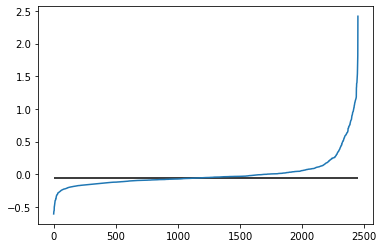

In [0]:
! pip install localreg
import localreg

# https://www.biorxiv.org/content/biorxiv/early/2018/11/02/460147.full.pdf 
# Page 12-13: Data preprocessing - Feature selection for individual datasets

# mean and variance of each gene of the unnormalized data
mean, var = np.mean(x, axis=0), np.var(x, axis=0)

# model log10(var)~log10(mean) by local fitting of polynomials of degree 2 
fitted = localreg.localreg(np.log10(mean), np.log10(var), 
                           x0=None, degree=2, kernel=localreg.gaussian, frac=0.3)

# standardized feature
z = (x - mean)/np.sqrt(10**fitted)

# clipped the standardized features to remove outliers
z[z>np.sqrt(n)] = np.sqrt(n)
# the variance of standardized features across all cells represents a measure of 
# single cell dispersion after controlling for mean expression
feature_score = np.var(z, axis=0)

plt.plot(np.log(np.sort(feature_score)))
quart_quantile = np.quantile(feature_score,0.45)
plt.hlines(np.log(quart_quantile), 1, p)

In [0]:
# X = x[:,np.argsort(feature_score)[-2000:]]
# X_normalized = x_normalized[:,np.argsort(feature_score)[-2000:]]
# Scale_factor = scale_factor / np.sum(X, axis=1) * np.sum(x, axis=1)

X = x[:,feature_score>quart_quantile]
X_normalized = x_normalized[:,feature_score>quart_quantile]
# Scale_factor = np.sum(X,axis=1, keepdims=True)/1e4
# X_normalized = np.log(X/Scale_factor + 1)
# Scale_factor = scale_factor / np.sum(X, axis=1) * np.sum(x, axis=1)

## Label Encoding

In [0]:
y = grouping

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(np.unique(grouping))
y = le.transform(grouping) 
le.classes_

array(['Cartilage cell_Clu high(Neonatal-Rib)',
       'Cartilage cell_Col2a1 high(Neonatal-Rib)',
       'Cartilage cell_Cxcl14 high(Neonatal-Rib)',
       'Cartilage cell_Ppa1 high(Neonatal-Rib)',
       'Cartilage cell_Prg4 high(Neonatal-Rib)'], dtype='<U40')

               0
               ^
               |  
     3 <- 1 <- 2 -> 4
  

# Building model

## Encoder

In [0]:
class Sampling(Layer):
    """
    Sampling latent variable z by (z_mean, z_log_var).    
    Used in Encoder.
    """
    def call(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        z = tf.clip_by_value(z, -1e6, 1e6)
        return z


class Encoder(Layer):
    '''
    Encoder, model q(z|x).
    '''
    def __init__(self, dimensions, dim_latent, name='encoder', **kwargs):
        '''
        Input:
          dimensions  - list of dimensions of layers in dense layers of 
                       encoder expcept the latent layer.
          dim_latent  - dimension of latent layer.
        '''
        super(Encoder, self).__init__(name=name, **kwargs)      
        self.dense_layers = [Dense(dim, activation='relu', 
                                          name='encoder_%i'%(i+1)) \
                             for (i,dim) in enumerate(dimensions)]
        self.batch_norm_layers = [BatchNormalization() \
                                    for _ in range(len((dimensions)))]
        self.latent_mean = Dense(dim_latent, name='latent_mean')
        self.latent_log_var = Dense(dim_latent, name='latent_log_var')
        self.sampling = Sampling()

    def call(self, x):
        '''
        Input :
            x           - input                     [batch_size, dim_origin]
        Output:            
            z_mean      - mean of p(z|x)            [batch_size, dim_latent]
            z_log_var   - log of variance of p(z|x) [batch_size, dim_latent]
            z           - sampled z                 [batch_size, dim_latent]
        '''        
        for dense, bn in zip(self.dense_layers, self.batch_norm_layers):
            x = dense(x)
            x = bn(x)        
        z_mean = self.latent_mean(x)
        z_log_var = self.latent_log_var(x)
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z

## Decoder

In [0]:
class Decoder(Layer):
    '''
    Decoder, model p(x|z).
    '''
    def __init__(self, dimensions, dim_origin,
                 data_type='UMI', name='decoder', **kwargs):
        '''
        Input:
            dimensions  - list of dimensions of layers in dense layers of 
                                decoder expcept the output layer.
            dim_origin  - dimension of output layer.
        '''
        super(Decoder, self).__init__(name=name, **kwargs)
        self.data_type = data_type
        self.dense_layers = [Dense(dim, activation='relu', 
                                          name='decoder_%i'%(i+1)) \
                             for (i,dim) in enumerate(dimensions)]
        self.batch_norm_layers = [BatchNormalization() \
                                    for _ in range(len((dimensions)))]                             
        self.log_lambda_z = Dense(dim_origin, name='log_lambda_z')
                
        # dispersion parameter
        self.log_r = tf.Variable(tf.zeros([1, dim_origin]), 
                                 constraint=lambda t: tf.clip_by_value(t,-30.,6.), 
                                 name="log_r")
        
        if self.data_type=='non-UMI':
            self.phi = Dense(dim_origin, activation='sigmoid', name="phi")
            
    def call(self, z):
        '''
        Input :
            z           - latent variables  [batch_size, dim_origin]
        Output:
            lambda_z    - x_hat             [batch_size, dim_origin]
            r           - dispersion parameter
                                            [1,          dim_origin]
        '''
        for dense, bn in zip(self.dense_layers, self.batch_norm_layers):
            z = dense(z)
            z = bn(z)      
        lambda_z = tf.math.exp(self.log_lambda_z(z))
        r = tf.exp(self.log_r)
        if self.data_type=='UMI':
            return lambda_z, r
        else:
            return lambda_z, r, self.phi(z)

## GMM

In [0]:
class GMM(Layer):
    '''
    GMM layer. 
    It contains parameters related to model assumptions of GMM. 
    '''
    def __init__(self, n_clusters, dim_latent, M=100, name='GMM', **kwargs):
        '''
        Input:
          dim_latent   - dimension of latent layer.
          dim_origin - dimension of output layer.
          M            - number of samples for w.
        '''
        super(GMM, self).__init__(name=name, **kwargs)
        self.dim_latent = dim_latent 
        self.n_clusters = n_clusters
        self.n_states = int(n_clusters*(n_clusters+1)/2)

        # nonzero indexes
        # A = [0,0,...,0  , 1,1,...,1,   ...]
        # B = [0,1,...,k-1, 1,2,...,k-1, ...]
        self.A, self.B = np.nonzero(np.triu(np.ones(n_clusters)))
        self.A = tf.convert_to_tensor(self.A, tf.int32)
        self.B = tf.convert_to_tensor(self.B, tf.int32)
        self.clusters_ind = tf.boolean_mask(
            tf.range(0,self.n_states,1), self.A==self.B)    


        # Uniform random variable
        self.M = tf.convert_to_tensor(M, tf.int32)
        self.w =  tf.convert_to_tensor(
            np.resize(np.arange(0,M)/M, (1, M)), tf.float32)

        # [pi_1, ... , pi_K] in R^(n_states)
        self.pi = tf.Variable(tf.ones([1, self.n_states]) / self.n_states, 
                                name='pi')
        
        # [mu_1, ... , mu_K] in R^(dim_latent * n_clusters)
        self.mu = tf.Variable(tf.random.uniform([self.dim_latent, self.n_clusters],
                                                minval=-1,maxval=1),
                                name="mu")        
                
        # [diag(Sigma_1), ... , diag(Sigma_K)] in R^(dim_latent * n_clusters)
        # self.Sigma = tf.Variable(tf.ones([self.dim_latent, self.n_clusters]), 
        #                          constraint=lambda x: tf.clip_by_value(x, 1e-30, np.infty),
        #                          name="Sigma")
    
    def initialize(self, mu, Sigma, pi):
        # Initialize mu and sigma computed by GMM
        self.pi.assign(pi)
        self.mu.assign(mu)

        # self.Sigma.assign(Sigma)

    def call(self, z, cluster=False, inference=False):       
        '''
        Input :
                z       - latent variables outputed by the encoder
                          [batch_size, dim_latent]
        Output:
                p_z     - MC samples for p(z)=sum_{c,w}(p_zc_w)/M
                          [batch_size, ]
                p_zc_w  - MC samples for p(z,c|w)=p(z|w,c)p(c) (L=1)
                          [batch_size, n_states, M]                         
        ''' 
        batch_size = tf.shape(z)[0]
        
        if cluster:
            # [batch_size, dim_latent, n_clusters]
            temp_Z = tf.tile(tf.expand_dims(z,-1),
                        (1,1,self.n_clusters))                                  
            temp_mu = tf.tile(
                            tf.expand_dims(
                                self.mu,0), 
                            (batch_size,1,1))    
            distance = tf.sqrt(tf.reduce_sum(tf.math.square(temp_Z - temp_mu),1))
            c = tf.argmin(distance, 1)
            cluster_loss = tf.reduce_mean(
                tf.reduce_max(tf.exp(-distance),1)/
                (tf.reduce_sum(tf.exp(-distance),1)+1e-30) 
                )

            return self.mu, c, cluster_loss                                            
        else:
            # [batch_size, dim_latent, n_states, M]
            temp_Z = tf.tile(tf.expand_dims(tf.expand_dims(z,-1), -1),
                        (1,1,self.n_states,self.M))                      
            temp_mu = tf.tile(
                            tf.expand_dims(tf.expand_dims(
                                tf.gather(self.mu, self.A, axis=1),0),-1), 
                            (batch_size,1,1,self.M)) * self.w + \
                    tf.tile(
                            tf.expand_dims(tf.expand_dims(
                                tf.gather(self.mu, self.B, axis=1),0),-1),
                            (batch_size,1,1,self.M)) * (1-self.w)
                
            # [batch_size, n_states, M]
            temp_pi = tf.tile(
                            tf.expand_dims(tf.nn.softmax(self.pi), -1),
                            (batch_size, 1, self.M))            
            log_p_zc_w = - 0.5 * self.dim_latent * tf.math.log(2 * math.pi) + \
                            tf.math.log(temp_pi+1e-30) - \
                            tf.reduce_sum(tf.math.square(temp_Z - temp_mu)/2, 1)                        
            # [batch_size, ]                            
            log_p_z = tf.math.reduce_logsumexp(log_p_zc_w, axis=[1,2]) \
                        - tf.math.log(tf.cast(self.M, tf.float32))
                                
            if inference:
                # p_c_x     -   predicted probability distribution
                p_c_x = tf.math.reduce_logsumexp(log_p_zc_w, axis=2)                              
                # w         -   E(w|x)                
                w =  tf.squeeze(
                        tf.tile(self.w, (batch_size,1)) *
                        tf.exp(tf.math.reduce_logsumexp(log_p_zc_w, axis=1))) /
                        tf.expand_dims(tf.exp(log_p_z)+1e-30, -1) / 
                        tf.cast(self.M, tf.float32)
                    )
                # var_w     -   Var(w|x)
                var_w =  tf.squeeze(
                            tf.square(tf.tile(self.w, (batch_size,1)) - w) *
                            tf.exp(tf.math.reduce_logsumexp(log_p_zc_w, axis=1))) /
                            tf.expand_dims(tf.exp(log_p_z)+1e-30, -1) / 
                            tf.cast(self.M, tf.float32)
                        )
                # c         -   predicted clusters 
                c = tf.math.argmax(
                    tf.math.reduce_logsumexp(log_p_zc_w, axis=2), axis=1)
                c = tf.cast(c, 'int32')
                c = tf.where(w>0, c, 
                             tf.gather(self.clusters_ind, tf.gather(self.A, c)))
                c = tf.where(w<1, c, 
                             tf.gather(self.clusters_ind, tf.gather(self.B, c)))                      
                # proj_z    -   projection of z to the segment of two clusters
                #               in the latent space
                proj_z = tf.transpose(
                    tf.gather(self.mu, tf.gather(self.A, c), axis=1) * 
                    tf.expand_dims(w, 0) + 
                    tf.gather(self.mu, tf.gather(self.B, c), axis=1) * 
                    (1-tf.expand_dims(w, 0)))
                return tf.nn.softmax(self.pi), self.mu, log_p_z, c, w, var_w, proj_z
            else:
                return tf.nn.softmax(self.pi), self.mu, log_p_z

## VaDE

In [0]:
class VariationalAutoEncoder(tf.keras.Model):
    """
    Combines the encoder, decoder and GMM into an end-to-end model for training.
    """
    def __init__(self, n_clusters, dim_origin, dimensions, dim_latent,
                 data_type='UMI', name='autoencoder', **kwargs):
        '''
        Args:
            n_clusters  -   Number of clusters.
            dim_origin  -   Dim of input.
            dimensions  -   List of dimensions of layers of the encoder. Assume 
                            symmetric network sturcture of encoder and decoder.
            dim_latent  -   Dimension of latent layer.
            data_type   -   Type of count data. 
                            'UMI' for negative binomial loss;
                            'non-UMI' for zero-inflated negative binomial loss.            
        '''
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.data_type = data_type
        self.dim_origin = dim_origin
        self.dim_latent = dim_latent 
        self.n_clusters = n_clusters

        self.encoder = Encoder(dimensions, dim_latent)
        self.GMM = GMM(n_clusters, dim_latent)
        self.decoder = Decoder(dimensions[::-1], dim_origin, data_type)
    
    def call(self, x_normalized, x=None, scale_factor=1, 
             cluster=False, inference=False, pre_train=False):
        # Feed forward through encoder, GMM layer and decoder.
        z_mean, z_log_var, z = self.encoder(x_normalized)        

        if self.data_type == 'UMI':
            x_hat, r = self.decoder(z)        
        else:
            x_hat, r, phi = self.decoder(z)  

        if cluster:
            mu, c, cluster_loss = self.GMM(z, cluster=cluster)
            self.add_loss(cluster_loss)
            return None
        elif inference:
            pi_norm, mu, log_p_z, c, w, var_w, proj_z = self.GMM(z, inference=inference)
            return pi_norm, mu, c, w, var_w, z, proj_z

        x_hat = x_hat*scale_factor

        # Negative Log-Likelihood Loss function

        # Ref for NB & ZINB loss functions:
        # https://github.com/gokceneraslan/neuralnet_countmodels/blob/master/Count%20models%20with%20neuralnets.ipynb
        # Negative Binomial loss

        neg_E_nb = tf.math.lgamma(r) + tf.math.lgamma(x+1.0) \
                    - tf.math.lgamma(x+r) + \
                    (r+x) * tf.math.log(1.0 + (x_hat/r)) + \
                    x * (tf.math.log(r) - tf.math.log(x_hat+1e-30))
        
        if self.data_type == 'non-UMI':
            # Zero-Inflated Negative Binomial loss
            nb_case = neg_E_nb - tf.math.log(1.0-phi+1e-30)                        
            zero_case = - tf.math.log(phi + (1.0-phi) * 
                                 tf.pow(r/(r + x_hat + 1e-30), r) + 1e-30)
            neg_E_nb = tf.where(tf.less(x, 1e-8), zero_case, nb_case)

        neg_E_nb =  tf.reduce_mean(tf.reduce_sum(neg_E_nb, axis=-1))
        self.add_loss(neg_E_nb)        
        if pre_train:    
            return None    
        else:
            pi_norm, mu, log_p_z = self.GMM(z, inference=inference)

            # - E_q[log p(z)]
            neg_E_pz = tf.reduce_mean(- log_p_z)
            self.add_loss(neg_E_pz)

            # - Eq[log q(z|x)]
            E_qzx = - tf.reduce_mean(                        
                            0.5 * self.dim_latent * 
                            (tf.math.log(2 * math.pi) + 1) +
                            0.5 * tf.reduce_sum(z_log_var, axis=-1)
                            )                        
            self.add_loss(E_qzx)            
            return None

# Compile model and train

In [0]:
class Early_Stopping():
    def __init__(self, warmup=0, patience=10, tolerance=1e-3, is_minimize=True):        
        self.warmup = warmup
        self.patience = patience
        self.tolerance = tolerance
        self.is_minimize = is_minimize

        self.step = 0
        self.best_step = 0
        self.best_metric = 0

        if not self.is_minimize:
            self.factor = -1
        else:
            self.factor = 1

    def __call__(self, metric):

        if self.step == 0:            
            self.best_step = 1
            self.best_metric = metric
            self.step += 1
            return False        

        self.step += 1            

        if self.factor*metric<self.factor*self.best_metric-self.tolerance:
            self.best_metric = metric
            self.best_step = self.step            
        elif self.step - self.best_step>self.patience:
            if self.step < self.warmup:
                return False
            else:
                print('Best Epoch: %d. Best Metric: %f.'%(self.best_step, self.best_metric))
                return True

In [0]:
tf.keras.backend.clear_session()

# Hyperparamter
BATCH_SIZE = 32
NUM_EPOCH_PRE = 300
NUM_STEP_PER_EPOCH = X.shape[0]//BATCH_SIZE+1
NUM_EPOCH = 1000

NUM_CLUSTER = len(np.unique(y)) 
DIM_LATENT = 16
DIM_ORIGIN = X.shape[1]

# Load data and preprocess.
train_dataset = tf.data.Dataset.from_tensor_slices((X_normalized, X_normalized, Scale_factor))
# train_dataset = tf.data.Dataset.from_tensor_slices((X, X_normalized, Scale_factor))
train_dataset = train_dataset.shuffle(buffer_size=n).batch(BATCH_SIZE)

vae = VariationalAutoEncoder(NUM_CLUSTER, DIM_ORIGIN, [128,32], DIM_LATENT,
                             data_type='non-UMI') # [128,32]

# vae.load_weights('/content/drive/My Drive/Data/train.checkpoint')

## Pretrain

In [0]:
# ---------------------------------------------------------------------------- #
# Pretrain for optimizing encoder and decoder networks.
# ---------------------------------------------------------------------------- #
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_metric = tf.keras.metrics.Mean()
mae_loss_fn = tf.keras.losses.MeanAbsoluteError()
early_stopping = Early_Stopping(patience=10, tolerance=1e-3)
for epoch in range(NUM_EPOCH_PRE):
    progbar = Progbar(NUM_STEP_PER_EPOCH)
    
    print('Pretrain - Start of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch, x_norm_batch, s) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae(x_norm_batch, x_batch, s, pre_train=True)
            # Compute reconstruction loss
            loss = tf.reduce_sum(vae.losses[0]) # mae_loss_fn(x_batch, reconstructed)
            
        grads = tape.gradient(loss, vae.trainable_weights, 
                              unconnected_gradients=tf.UnconnectedGradients.ZERO)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))
        loss_metric(loss)
        
        if (step+1)%10==0 or step+1==NUM_STEP_PER_EPOCH:
            progbar.update(step+1, [('Reconstructed Loss', float(loss))])
    if early_stopping(float(loss_metric.result())):
        print('Early stopping.')
        break
    print(' Training loss over epoch: %s' % (float(loss_metric.result()),))                                  
    loss_metric.reset_states()

print('Pretrain Done.')
vae.save_weights('/content/drive/My Drive/Data/pre_train.checkpoint')

Pretrain - Start of epoch 0
70/70 [==============================] - 3s 48ms/step - Reconstructed Loss: 521.9799
 Training loss over epoch: 534.4542846679688
Pretrain - Start of epoch 1
70/70 [==============================] - 3s 50ms/step - Reconstructed Loss: 437.9919
 Training loss over epoch: 426.7799072265625
Pretrain - Start of epoch 2
70/70 [==============================] - 3s 47ms/step - Reconstructed Loss: 439.2953
 Training loss over epoch: 422.16986083984375
Pretrain - Start of epoch 3
70/70 [==============================] - 3s 45ms/step - Reconstructed Loss: 413.0289
 Training loss over epoch: 417.26470947265625
Pretrain - Start of epoch 4
70/70 [==============================] - 3s 48ms/step - Reconstructed Loss: 413.9754
 Training loss over epoch: 411.9930114746094
Pretrain - Start of epoch 5
70/70 [==============================] - 3s 48ms/step - Reconstructed Loss: 407.7512
 Training loss over epoch: 407.1430969238281
Pretrain - Start of epoch 6
70/70 [===============

## Initialize mu

In [0]:
# ---------------------------------------------------------------------------- #
# Initialize paramters of GMM
# ---------------------------------------------------------------------------- #
_, _, z = vae.encoder(X_normalized)
gmm = GaussianMixture(n_components=NUM_CLUSTER, covariance_type='diag')
gmm.fit(z)
# acc_0 = np.mean(gmm.predict(z).ravel() == y.ravel())
means_0 = gmm.means_
covs_0 = gmm.covariances_


pred_c = gmm.predict(z)
n_states = int((NUM_CLUSTER+1)*NUM_CLUSTER/2)
pi = np.zeros((1,n_states))
cluster_center = [int((NUM_CLUSTER+(1-i)/2)*i) for i in range(NUM_CLUSTER)]
for i in range(NUM_CLUSTER):
    pi[0,cluster_center[i]] = np.sum(pred_c==i)
pi = pi / np.sum(pi)

vae.GMM.initialize(means_0.T, covs_0, pi)
# print(acc_0)

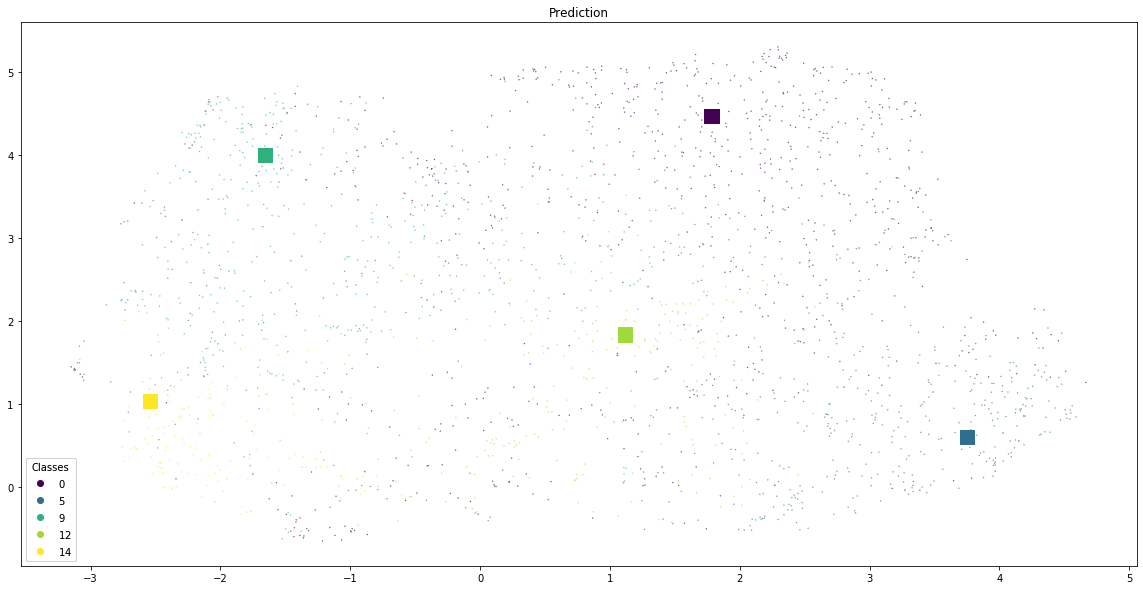

In [0]:
pi,mu,c,w,var_w,z,proj_z = vae(X_normalized, inference=True)

fit = umap.UMAP()
uz = fit.fit_transform(z)
u = fit.transform(mu.numpy().T)
plt.figure(figsize=(20,10))
ax = plt.subplot(111)
scatter = plt.scatter(uz[:,0], uz[:,1], c=c, s=0.1)
ax.set_title('Prediction')        
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
cluster_center = [(NUM_CLUSTER+(1-i)/2)*i for i in range(NUM_CLUSTER)]  
plt.scatter(u[:,0], u[:,1], c=cluster_center, s=200, marker='s')
plt.show()

## Training without clustering loss

Start of epoch 0
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 365.4972 - loss_neg_E_pz: 706.1007 - loss_E_qzx   : 312.1854 - loss_total: 1496.4851
 Training loss over epoch: 1418.6351318359375
 369.240967,  726.582031,  322.812714


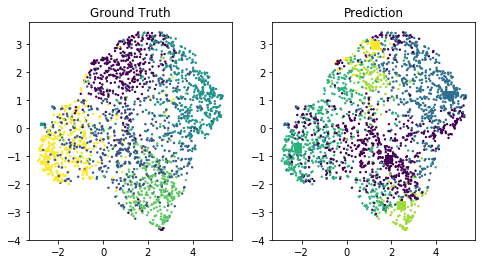

Start of epoch 1
70/70 [==============================] - 7s 107ms/step - loss_neg_E_nb: 380.7157 - loss_neg_E_pz: 514.5919 - loss_E_qzx   : 238.7807 - loss_total: 1203.0781
 Training loss over epoch: 1172.2069091796875
 396.969208,  532.495544,  242.742020
Start of epoch 2
70/70 [==============================] - 7s 104ms/step - loss_neg_E_nb: 405.4211 - loss_neg_E_pz: 428.4636 - loss_E_qzx   : 197.2561 - loss_total: 1061.4621
 Training loss over epoch: 1044.22998046875
 415.757965,  427.540771,  200.931229
Start of epoch 3
70/70 [==============================] - 7s 105ms/step - loss_neg_E_nb: 423.5416 - loss_neg_E_pz: 336.8127 - loss_E_qzx   : 179.7594 - loss_total: 972.0408
 Training loss over epoch: 959.8634033203125
 426.739075,  358.226257,  174.898163
Start of epoch 4
70/70 [==============================] - 7s 106ms/step - loss_neg_E_nb: 418.9047 - loss_neg_E_pz: 309.1869 - loss_E_qzx   : 153.6875 - loss_total: 910.5607
 Training loss over epoch: 896.2316284179688
 431.522552,

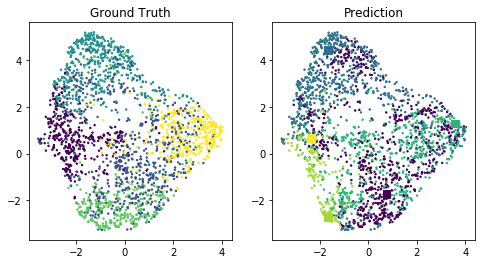

Start of epoch 11
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 429.4768 - loss_neg_E_pz: 169.5328 - loss_E_qzx   : 74.7303 - loss_total: 686.4605
 Training loss over epoch: 680.5946044921875
 440.717560,  164.834991,  75.042007
Start of epoch 12
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 442.3690 - loss_neg_E_pz: 155.3547 - loss_E_qzx   : 67.2399 - loss_total: 661.2569
 Training loss over epoch: 662.9885864257812
 440.113098,  155.095459,  67.779999
Start of epoch 13
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 450.6779 - loss_neg_E_pz: 146.2434 - loss_E_qzx   : 60.0361 - loss_total: 647.3827
 Training loss over epoch: 648.4822387695312
 439.906158,  147.591217,  60.984882
Start of epoch 14
70/70 [==============================] - 8s 108ms/step - loss_neg_E_nb: 417.3286 - loss_neg_E_pz: 137.1367 - loss_E_qzx   : 53.2243 - loss_total: 635.4255
 Training loss over epoch: 633.9415283203125
 438.848419,  140

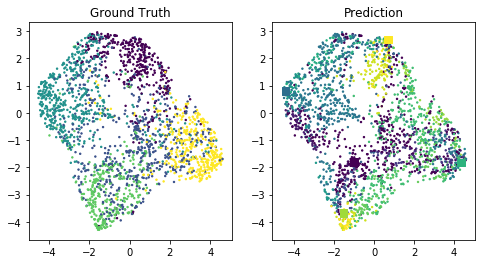

Start of epoch 21
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 421.5828 - loss_neg_E_pz: 108.0669 - loss_E_qzx   : 27.6357 - loss_total: 575.4196
 Training loss over epoch: 574.808837890625
 438.261261,  108.570885,  27.976669
Start of epoch 22
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 428.4171 - loss_neg_E_pz: 102.5306 - loss_E_qzx   : 26.5529 - loss_total: 568.1397
 Training loss over epoch: 568.876953125
 437.630585,  105.252182,  25.994339
Start of epoch 23
70/70 [==============================] - 8s 108ms/step - loss_neg_E_nb: 452.6182 - loss_neg_E_pz: 99.8748 - loss_E_qzx   : 24.9076 - loss_total: 564.3638
 Training loss over epoch: 564.8472290039062
 437.613953,  102.685570,  24.547714
Start of epoch 24
70/70 [==============================] - 7s 106ms/step - loss_neg_E_nb: 431.8359 - loss_neg_E_pz: 96.3920 - loss_E_qzx   : 22.6268 - loss_total: 555.0697
 Training loss over epoch: 558.7005615234375
 435.867065,  99.926468,

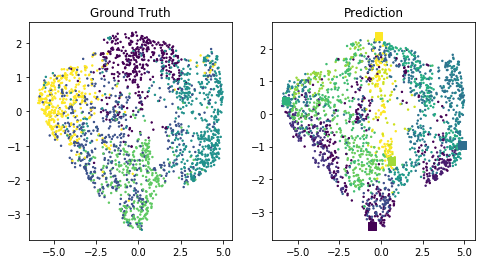

Start of epoch 31
70/70 [==============================] - 7s 105ms/step - loss_neg_E_nb: 431.3046 - loss_neg_E_pz: 84.5229 - loss_E_qzx   : 12.9356 - loss_total: 529.3676
 Training loss over epoch: 534.0677490234375
 433.440460,  86.763893,  13.863492
Start of epoch 32
70/70 [==============================] - 7s 106ms/step - loss_neg_E_nb: 448.7322 - loss_neg_E_pz: 84.3389 - loss_E_qzx   : 12.4399 - loss_total: 531.3506
 Training loss over epoch: 533.0532836914062
 434.154846,  85.866066,  13.032285
Start of epoch 33
70/70 [==============================] - 7s 105ms/step - loss_neg_E_nb: 437.1600 - loss_neg_E_pz: 82.4881 - loss_E_qzx   : 13.6212 - loss_total: 529.6341
 Training loss over epoch: 529.6796875
 432.681335,  84.209061,  12.789330
Start of epoch 34
70/70 [==============================] - 7s 107ms/step - loss_neg_E_nb: 411.9529 - loss_neg_E_pz: 85.0905 - loss_E_qzx   : 11.3605 - loss_total: 522.4787
 Training loss over epoch: 526.6468505859375
 431.862061,  82.987122,  11.7

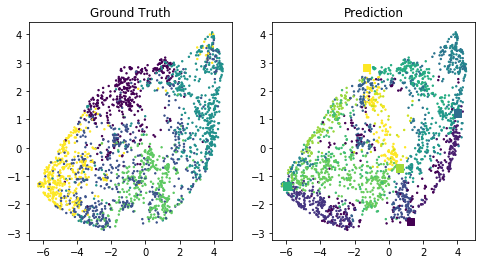

Start of epoch 41
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 438.2921 - loss_neg_E_pz: 76.6262 - loss_E_qzx   : 8.4074 - loss_total: 509.9122
 Training loss over epoch: 512.6936645507812
 429.089325,  75.680702,  7.923644
Start of epoch 42
70/70 [==============================] - 8s 108ms/step - loss_neg_E_nb: 416.4622 - loss_neg_E_pz: 73.7474 - loss_E_qzx   : 7.4373 - loss_total: 510.1086
 Training loss over epoch: 510.0606689453125
 428.009094,  74.412506,  7.639166
Start of epoch 43
70/70 [==============================] - 8s 108ms/step - loss_neg_E_nb: 415.8363 - loss_neg_E_pz: 72.2591 - loss_E_qzx   : 6.3868 - loss_total: 508.7867
 Training loss over epoch: 508.2021789550781
 427.398590,  73.789268,  7.014331
Start of epoch 44
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 437.3348 - loss_neg_E_pz: 71.7536 - loss_E_qzx   : 6.8667 - loss_total: 506.0277
 Training loss over epoch: 507.24737548828125
 427.338104,  73.012527,  6.89

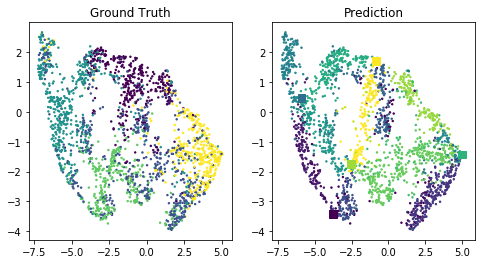

Start of epoch 51
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 422.2949 - loss_neg_E_pz: 68.9937 - loss_E_qzx   : 3.5684 - loss_total: 493.1040
 Training loss over epoch: 496.861328125
 424.235138,  68.298965,  4.327137
Start of epoch 52
70/70 [==============================] - 7s 107ms/step - loss_neg_E_nb: 423.7528 - loss_neg_E_pz: 70.2156 - loss_E_qzx   : 3.7967 - loss_total: 488.9719
 Training loss over epoch: 495.8019104003906
 424.075226,  67.437225,  4.289474
Start of epoch 53
70/70 [==============================] - 8s 107ms/step - loss_neg_E_nb: 424.1790 - loss_neg_E_pz: 65.8237 - loss_E_qzx   : 3.5323 - loss_total: 497.5114
 Training loss over epoch: 495.1058044433594
 424.160065,  66.982414,  3.963314
Start of epoch 54
70/70 [==============================] - 7s 106ms/step - loss_neg_E_nb: 410.8413 - loss_neg_E_pz: 67.0432 - loss_E_qzx   : 3.1702 - loss_total: 493.4653
 Training loss over epoch: 492.6089172363281
 422.737518,  66.276192,  3.595182


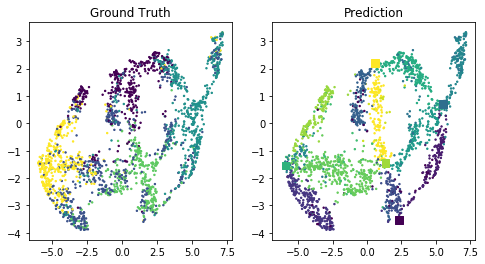

Start of epoch 61
70/70 [==============================] - 8s 107ms/step - loss_neg_E_nb: 431.8146 - loss_neg_E_pz: 64.0844 - loss_E_qzx   : 2.2017 - loss_total: 485.0142
 Training loss over epoch: 485.7518005371094
 420.680817,  63.047188,  2.023772
Start of epoch 62
70/70 [==============================] - 7s 106ms/step - loss_neg_E_nb: 418.4798 - loss_neg_E_pz: 65.0660 - loss_E_qzx   : 1.8945 - loss_total: 484.0925
 Training loss over epoch: 484.61859130859375
 419.885559,  62.674747,  2.058264
Start of epoch 63
70/70 [==============================] - 7s 105ms/step - loss_neg_E_nb: 430.9192 - loss_neg_E_pz: 61.9854 - loss_E_qzx   : 0.8779 - loss_total: 485.3576
 Training loss over epoch: 483.240234375
 419.056793,  62.342781,  1.840642
Start of epoch 64
70/70 [==============================] - 7s 105ms/step - loss_neg_E_nb: 405.4709 - loss_neg_E_pz: 61.4818 - loss_E_qzx   : 1.2475 - loss_total: 480.7230
 Training loss over epoch: 482.3494873046875
 419.030548,  61.637291,  1.681601

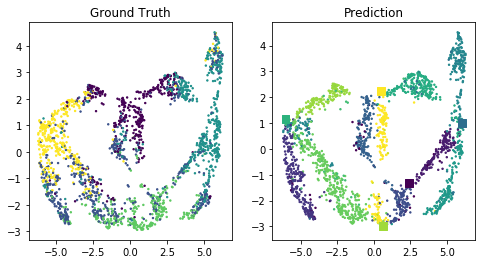

Start of epoch 71
70/70 [==============================] - 7s 106ms/step - loss_neg_E_nb: 422.8061 - loss_neg_E_pz: 59.1690 - loss_E_qzx   : 0.8552 - loss_total: 479.5780
 Training loss over epoch: 476.365966796875
 416.205597,  59.269791,  0.890528
Start of epoch 72
70/70 [==============================] - 7s 105ms/step - loss_neg_E_nb: 413.7672 - loss_neg_E_pz: 61.0511 - loss_E_qzx   : 1.5489 - loss_total: 476.2653
 Training loss over epoch: 475.80413818359375
 416.050385,  58.938148,  0.815603
Start of epoch 73
70/70 [==============================] - 7s 105ms/step - loss_neg_E_nb: 412.6994 - loss_neg_E_pz: 57.8850 - loss_E_qzx   : 0.9224 - loss_total: 477.3581
 Training loss over epoch: 475.26434326171875
 415.828949,  58.681446,  0.753894
Start of epoch 74
70/70 [==============================] - 7s 103ms/step - loss_neg_E_nb: 418.0934 - loss_neg_E_pz: 57.0141 - loss_E_qzx   : 0.6512 - loss_total: 475.5429
 Training loss over epoch: 474.2698059082031
 415.421936,  58.149487,  0.69

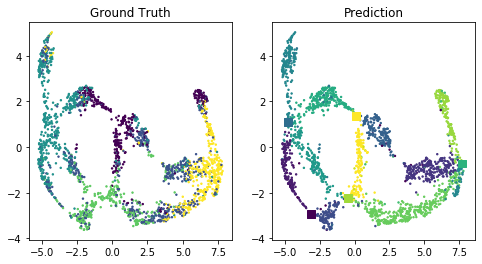

Start of epoch 81
70/70 [==============================] - 7s 103ms/step - loss_neg_E_nb: 416.0760 - loss_neg_E_pz: 55.0344 - loss_E_qzx   : 0.1877 - loss_total: 469.0536
 Training loss over epoch: 469.9874572753906
 413.565430,  56.089600,  0.332417
Start of epoch 82
70/70 [==============================] - 7s 106ms/step - loss_neg_E_nb: 432.2169 - loss_neg_E_pz: 56.3172 - loss_E_qzx   : 0.1744 - loss_total: 467.0339
 Training loss over epoch: 468.86468505859375
 412.630341,  56.190804,  0.043528
Start of epoch 83
70/70 [==============================] - 7s 105ms/step - loss_neg_E_nb: 432.8498 - loss_neg_E_pz: 56.8661 - loss_E_qzx   : 0.2483 - loss_total: 471.6862
 Training loss over epoch: 469.4815368652344
 413.608063,  55.828671,  0.044805
Start of epoch 84
70/70 [==============================] - 8s 107ms/step - loss_neg_E_nb: 411.8092 - loss_neg_E_pz: 55.4370 - loss_E_qzx   : -0.2305 - loss_total: 464.9151
 Training loss over epoch: 467.9050598144531
 412.427795,  55.572876, -0.0

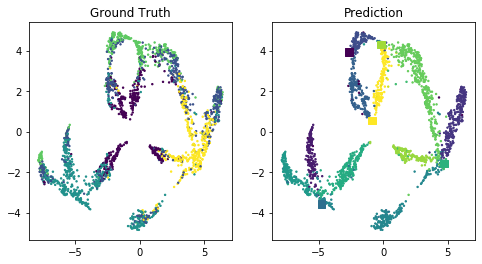

Start of epoch 91
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 401.1695 - loss_neg_E_pz: 55.5283 - loss_E_qzx   : -0.6144 - loss_total: 465.2413
 Training loss over epoch: 463.2967529296875
 409.518005,  54.122601, -0.343845
Start of epoch 92
70/70 [==============================] - 8s 107ms/step - loss_neg_E_nb: 430.7554 - loss_neg_E_pz: 54.3243 - loss_E_qzx   : -0.3125 - loss_total: 460.9606
 Training loss over epoch: 463.9718933105469
 410.473358,  54.017159, -0.518727
Start of epoch 93
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 421.0719 - loss_neg_E_pz: 53.6924 - loss_E_qzx   : -0.2365 - loss_total: 460.5979
 Training loss over epoch: 462.1213684082031
 408.598663,  53.811123, -0.288433
Start of epoch 94
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 402.8959 - loss_neg_E_pz: 52.1158 - loss_E_qzx   : -0.3487 - loss_total: 463.9300
 Training loss over epoch: 461.67041015625
 408.550049,  53.541351, -0.4

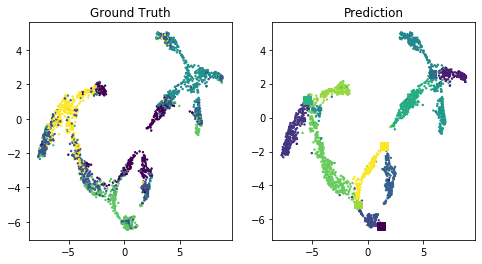

Start of epoch 101
70/70 [==============================] - 7s 104ms/step - loss_neg_E_nb: 400.6084 - loss_neg_E_pz: 51.2073 - loss_E_qzx   : -1.2711 - loss_total: 454.9358
 Training loss over epoch: 457.8973388671875
 406.411469,  52.292885, -0.806825
Start of epoch 102
70/70 [==============================] - 7s 105ms/step - loss_neg_E_nb: 408.5890 - loss_neg_E_pz: 53.9124 - loss_E_qzx   : -0.6430 - loss_total: 454.8193
 Training loss over epoch: 457.9115295410156
 406.587646,  52.172085, -0.848174
Start of epoch 103
70/70 [==============================] - 7s 105ms/step - loss_neg_E_nb: 415.0629 - loss_neg_E_pz: 51.8656 - loss_E_qzx   : -0.1996 - loss_total: 459.7986
 Training loss over epoch: 457.2308044433594
 406.069366,  52.013515, -0.852108
Start of epoch 104
70/70 [==============================] - 7s 106ms/step - loss_neg_E_nb: 419.2197 - loss_neg_E_pz: 52.2548 - loss_E_qzx   : -0.7481 - loss_total: 458.6615
 Training loss over epoch: 457.46356201171875
 406.226105,  51.99497

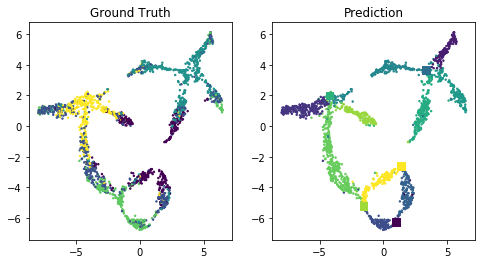

Start of epoch 111
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 427.4143 - loss_neg_E_pz: 51.8665 - loss_E_qzx   : -1.0187 - loss_total: 454.8727
 Training loss over epoch: 454.2371520996094
 404.187012,  50.894279, -0.844058
Start of epoch 112
70/70 [==============================] - 8s 108ms/step - loss_neg_E_nb: 412.9217 - loss_neg_E_pz: 49.0194 - loss_E_qzx   : -1.0253 - loss_total: 453.4554
 Training loss over epoch: 454.33477783203125
 404.662964,  50.768341, -1.096563
Start of epoch 113
70/70 [==============================] - 7s 106ms/step - loss_neg_E_nb: 398.2535 - loss_neg_E_pz: 51.4489 - loss_E_qzx   : -0.8328 - loss_total: 452.5354
 Training loss over epoch: 453.2901916503906
 403.405304,  50.658859, -0.773923
Start of epoch 114
70/70 [==============================] - 8s 108ms/step - loss_neg_E_nb: 388.3877 - loss_neg_E_pz: 50.2455 - loss_E_qzx   : -1.0888 - loss_total: 450.3918
 Training loss over epoch: 452.72210693359375
 402.939331,  50.5755

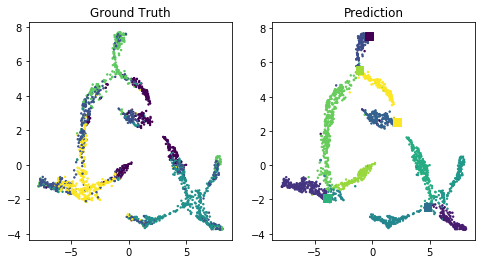

Start of epoch 121
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 389.5082 - loss_neg_E_pz: 47.2604 - loss_E_qzx   : -0.9517 - loss_total: 447.2872
 Training loss over epoch: 450.2508544921875
 401.290619,  49.751659, -0.791283
Start of epoch 122
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 387.7317 - loss_neg_E_pz: 49.6909 - loss_E_qzx   : -0.8475 - loss_total: 448.5506
 Training loss over epoch: 449.6556091308594
 400.975220,  49.642715, -0.962286
Start of epoch 123
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 403.4737 - loss_neg_E_pz: 50.9823 - loss_E_qzx   : -0.5531 - loss_total: 449.2826
 Training loss over epoch: 449.59625244140625
 400.668701,  49.701138, -0.773568
Start of epoch 124
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 423.8756 - loss_neg_E_pz: 48.0875 - loss_E_qzx   : -1.3031 - loss_total: 447.2809
 Training loss over epoch: 449.5251159667969
 401.171997,  49.37097

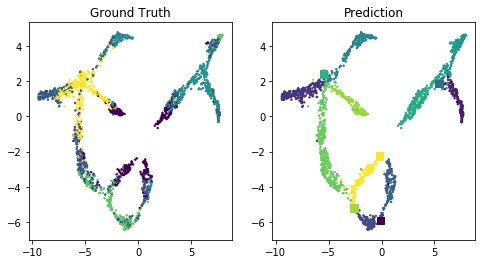

Start of epoch 131
70/70 [==============================] - 8s 114ms/step - loss_neg_E_nb: 380.5712 - loss_neg_E_pz: 47.5009 - loss_E_qzx   : -0.8052 - loss_total: 446.9527
 Training loss over epoch: 447.2539978027344
 399.244965,  48.781570, -0.772584
Start of epoch 132
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 383.9681 - loss_neg_E_pz: 48.9240 - loss_E_qzx   : -1.3266 - loss_total: 447.8833
 Training loss over epoch: 446.13934326171875
 398.343719,  48.684216, -0.888574
Start of epoch 133
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 393.6022 - loss_neg_E_pz: 47.7548 - loss_E_qzx   : -0.9691 - loss_total: 447.2889
 Training loss over epoch: 446.76617431640625
 399.129181,  48.488079, -0.850984
Start of epoch 134
70/70 [==============================] - 7s 107ms/step - loss_neg_E_nb: 408.9526 - loss_neg_E_pz: 49.9385 - loss_E_qzx   : -0.4486 - loss_total: 446.9035
 Training loss over epoch: 446.76788330078125
 399.242737,  48.488

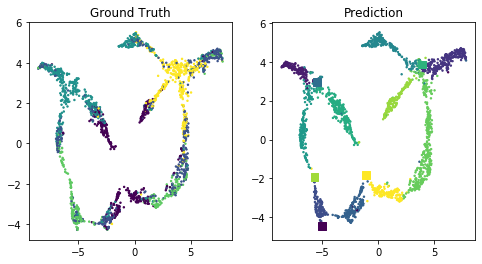

Start of epoch 141
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 374.4831 - loss_neg_E_pz: 46.4790 - loss_E_qzx   : -1.1334 - loss_total: 443.5315
 Training loss over epoch: 444.0863037109375
 396.932922,  47.897644, -0.744182
Start of epoch 142
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 400.2597 - loss_neg_E_pz: 48.3007 - loss_E_qzx   : -0.9598 - loss_total: 443.3654
 Training loss over epoch: 444.06365966796875
 396.963745,  47.812603, -0.712733
Start of epoch 143
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 371.4878 - loss_neg_E_pz: 47.0763 - loss_E_qzx   : -0.5483 - loss_total: 444.3078
 Training loss over epoch: 444.0076599121094
 396.853668,  47.827976, -0.674010
Start of epoch 144
70/70 [==============================] - 8s 114ms/step - loss_neg_E_nb: 372.4982 - loss_neg_E_pz: 46.8477 - loss_E_qzx   : -0.9142 - loss_total: 441.1727
 Training loss over epoch: 443.3892517089844
 396.597076,  47.61676

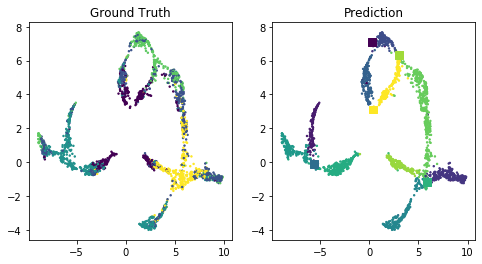

Start of epoch 151
70/70 [==============================] - 8s 107ms/step - loss_neg_E_nb: 388.3548 - loss_neg_E_pz: 47.4321 - loss_E_qzx   : -0.5673 - loss_total: 440.3421
 Training loss over epoch: 441.9637451171875
 395.326019,  47.162521, -0.524729
Start of epoch 152
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 405.0048 - loss_neg_E_pz: 46.4180 - loss_E_qzx   : -0.6502 - loss_total: 440.9176
 Training loss over epoch: 441.5698547363281
 395.036072,  47.090420, -0.556592
Start of epoch 153
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 397.8434 - loss_neg_E_pz: 45.8674 - loss_E_qzx   : -0.4030 - loss_total: 441.1511
 Training loss over epoch: 441.20751953125
 394.842926,  46.905243, -0.540587
Start of epoch 154
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 395.9160 - loss_neg_E_pz: 47.5591 - loss_E_qzx   : -0.8663 - loss_total: 438.8113
 Training loss over epoch: 441.12060546875
 394.680511,  46.966724, -0

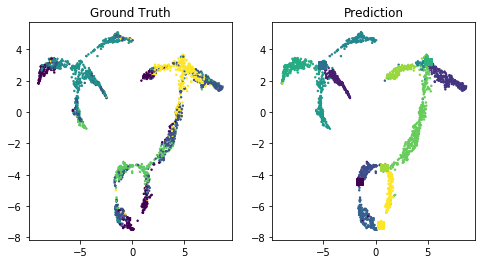

Start of epoch 161
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 383.1043 - loss_neg_E_pz: 45.5060 - loss_E_qzx   : -0.3410 - loss_total: 437.6073
 Training loss over epoch: 439.6710205078125
 393.532562,  46.529194, -0.390819
Start of epoch 162
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 405.1134 - loss_neg_E_pz: 46.5792 - loss_E_qzx   : -0.5919 - loss_total: 441.8409
 Training loss over epoch: 439.1678161621094
 393.166168,  46.472431, -0.470729
Start of epoch 163
70/70 [==============================] - 8s 108ms/step - loss_neg_E_nb: 399.3820 - loss_neg_E_pz: 46.2201 - loss_E_qzx   : -0.3975 - loss_total: 439.4066
 Training loss over epoch: 439.1962585449219
 393.179047,  46.500313, -0.483213
Start of epoch 164
70/70 [==============================] - 8s 108ms/step - loss_neg_E_nb: 381.3488 - loss_neg_E_pz: 46.1816 - loss_E_qzx   : -0.4858 - loss_total: 438.8952
 Training loss over epoch: 438.9299011230469
 393.039856,  46.322662

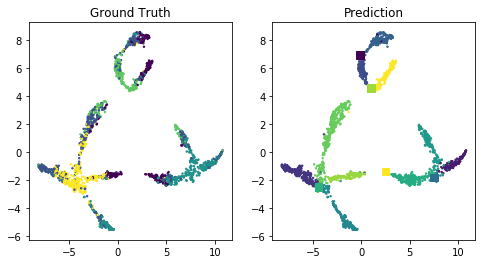

Start of epoch 171
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 403.5986 - loss_neg_E_pz: 45.1727 - loss_E_qzx   : -0.1343 - loss_total: 436.3314
 Training loss over epoch: 437.2939147949219
 391.760193,  45.881294, -0.347513
Start of epoch 172
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 388.6284 - loss_neg_E_pz: 46.5439 - loss_E_qzx   : -0.6188 - loss_total: 437.6994
 Training loss over epoch: 437.5096130371094
 391.949219,  46.029087, -0.468667
Start of epoch 173
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 373.5372 - loss_neg_E_pz: 44.2527 - loss_E_qzx   : -0.7497 - loss_total: 437.7623
 Training loss over epoch: 436.784912109375
 391.376709,  45.732918, -0.324611
Start of epoch 174
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 394.9544 - loss_neg_E_pz: 45.1892 - loss_E_qzx   : -0.1881 - loss_total: 433.7817
 Training loss over epoch: 437.01373291015625
 391.678986,  45.742031

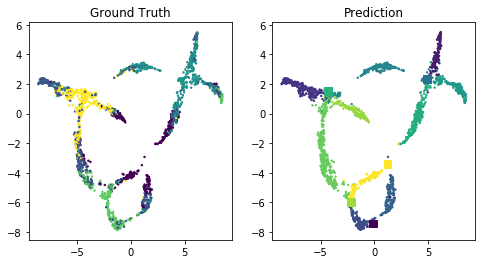

Start of epoch 181
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 375.1061 - loss_neg_E_pz: 45.1798 - loss_E_qzx   : -0.5094 - loss_total: 434.7666
 Training loss over epoch: 435.4588623046875
 390.448730,  45.423458, -0.413419
Start of epoch 182
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 398.1097 - loss_neg_E_pz: 46.2616 - loss_E_qzx   : 0.0687 - loss_total: 432.8687
 Training loss over epoch: 435.6935729980469
 390.735016,  45.296406, -0.337796
Start of epoch 183
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 387.3960 - loss_neg_E_pz: 45.1015 - loss_E_qzx   : -0.1657 - loss_total: 438.4518
 Training loss over epoch: 435.331298828125
 390.150269,  45.377663, -0.196642
Start of epoch 184
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 379.2820 - loss_neg_E_pz: 45.1756 - loss_E_qzx   : -0.4137 - loss_total: 436.9364
 Training loss over epoch: 435.3106994628906
 390.343628,  45.254467, 

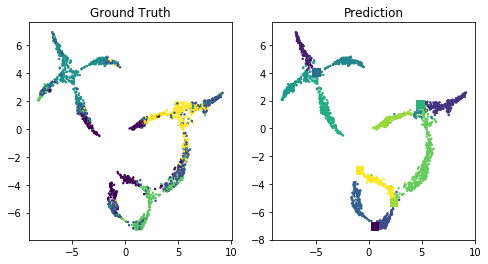

Start of epoch 191
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 404.0661 - loss_neg_E_pz: 44.7230 - loss_E_qzx   : 0.5536 - loss_total: 434.3983
 Training loss over epoch: 434.0223693847656
 389.038574,  44.874474,  0.109380
Start of epoch 192
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 389.3773 - loss_neg_E_pz: 46.6236 - loss_E_qzx   : -0.2511 - loss_total: 436.5014
 Training loss over epoch: 433.7228698730469
 388.904510,  44.898483, -0.080109
Start of epoch 193
70/70 [==============================] - 7s 106ms/step - loss_neg_E_nb: 391.9727 - loss_neg_E_pz: 45.5475 - loss_E_qzx   : 0.0445 - loss_total: 436.1987
 Training loss over epoch: 433.5513916015625
 388.761566,  44.759663,  0.030276
Start of epoch 194
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 368.3166 - loss_neg_E_pz: 45.0420 - loss_E_qzx   : -0.2971 - loss_total: 433.1400
 Training loss over epoch: 432.5454406738281
 387.941895,  44.696266, 

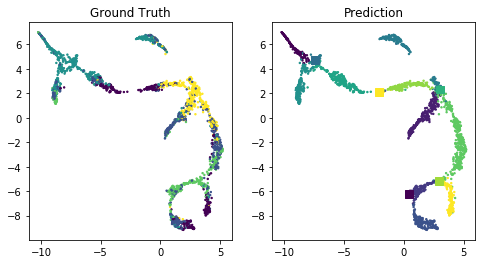

Start of epoch 201
70/70 [==============================] - 8s 117ms/step - loss_neg_E_nb: 402.0649 - loss_neg_E_pz: 45.6129 - loss_E_qzx   : 0.5316 - loss_total: 435.0014
 Training loss over epoch: 433.05322265625
 388.164520,  44.566330,  0.322339
Start of epoch 202
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 385.7683 - loss_neg_E_pz: 44.5402 - loss_E_qzx   : 0.4385 - loss_total: 434.3637
 Training loss over epoch: 432.4026794433594
 387.694977,  44.490089,  0.217597
Start of epoch 203
70/70 [==============================] - 8s 117ms/step - loss_neg_E_nb: 394.9783 - loss_neg_E_pz: 44.5759 - loss_E_qzx   : 0.4784 - loss_total: 430.2157
 Training loss over epoch: 432.71258544921875
 388.048615,  44.360367,  0.303678
Start of epoch 204
70/70 [==============================] - 8s 116ms/step - loss_neg_E_nb: 384.6256 - loss_neg_E_pz: 43.5154 - loss_E_qzx   : 0.0895 - loss_total: 432.1744
 Training loss over epoch: 431.6907043457031
 387.121216,  44.360142,  0.

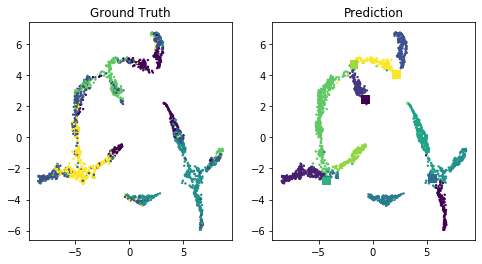

Start of epoch 211
70/70 [==============================] - 8s 114ms/step - loss_neg_E_nb: 386.5515 - loss_neg_E_pz: 43.0748 - loss_E_qzx   : 0.1169 - loss_total: 436.5337
 Training loss over epoch: 431.1947937011719
 386.872253,  44.028278,  0.294075
Start of epoch 212
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 398.4023 - loss_neg_E_pz: 43.6543 - loss_E_qzx   : 0.7455 - loss_total: 431.9195
 Training loss over epoch: 430.5220031738281
 386.120056,  44.061417,  0.340480
Start of epoch 213
70/70 [==============================] - 8s 114ms/step - loss_neg_E_nb: 378.3926 - loss_neg_E_pz: 44.0960 - loss_E_qzx   : 0.3127 - loss_total: 429.9662
 Training loss over epoch: 430.44122314453125
 386.167023,  43.913902,  0.360130
Start of epoch 214
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 384.9859 - loss_neg_E_pz: 43.1175 - loss_E_qzx   : 0.3775 - loss_total: 427.8305
 Training loss over epoch: 430.66656494140625
 386.373169,  43.886517, 

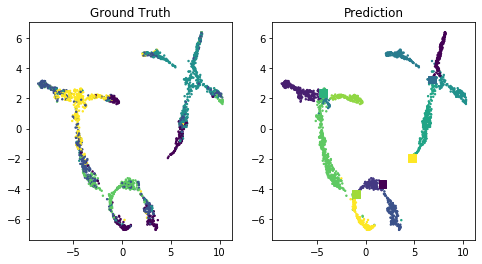

Start of epoch 221
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 390.1882 - loss_neg_E_pz: 44.1330 - loss_E_qzx   : 0.8753 - loss_total: 429.6426
 Training loss over epoch: 429.5206604003906
 385.191193,  43.741802,  0.587494
Start of epoch 222
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 390.0791 - loss_neg_E_pz: 42.8501 - loss_E_qzx   : 0.3928 - loss_total: 431.1901
 Training loss over epoch: 429.6220703125
 385.525757,  43.659401,  0.436927
Start of epoch 223
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 371.6171 - loss_neg_E_pz: 43.5322 - loss_E_qzx   : 0.3224 - loss_total: 423.8404
 Training loss over epoch: 428.76922607421875
 384.806305,  43.619732,  0.343086
Start of epoch 224
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 375.1256 - loss_neg_E_pz: 42.8804 - loss_E_qzx   : 0.4362 - loss_total: 430.7833
 Training loss over epoch: 429.0809020996094
 385.021759,  43.665405,  0.3

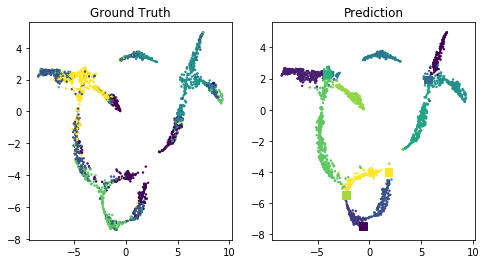

Start of epoch 231
70/70 [==============================] - 8s 116ms/step - loss_neg_E_nb: 375.9732 - loss_neg_E_pz: 44.0022 - loss_E_qzx   : 0.6512 - loss_total: 424.6577
 Training loss over epoch: 428.2354431152344
 384.370911,  43.277130,  0.587439
Start of epoch 232
70/70 [==============================] - 8s 120ms/step - loss_neg_E_nb: 375.6505 - loss_neg_E_pz: 43.4692 - loss_E_qzx   : 0.3979 - loss_total: 434.0682
 Training loss over epoch: 428.6562805175781
 384.581665,  43.313801,  0.760867
Start of epoch 233
70/70 [==============================] - 8s 120ms/step - loss_neg_E_nb: 369.1881 - loss_neg_E_pz: 42.7729 - loss_E_qzx   : 0.4074 - loss_total: 424.4335
 Training loss over epoch: 427.4346008300781
 383.517029,  43.302101,  0.615360
Start of epoch 234
70/70 [==============================] - 8s 114ms/step - loss_neg_E_nb: 397.6998 - loss_neg_E_pz: 44.1414 - loss_E_qzx   : 1.1032 - loss_total: 426.7935
 Training loss over epoch: 428.14971923828125
 383.970215,  43.284054,  

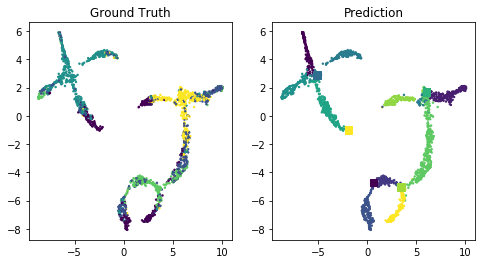

Start of epoch 241
70/70 [==============================] - 8s 118ms/step - loss_neg_E_nb: 365.7080 - loss_neg_E_pz: 42.3042 - loss_E_qzx   : 0.7254 - loss_total: 423.5019
 Training loss over epoch: 426.7737121582031
 382.828979,  43.023003,  0.921717
Start of epoch 242
70/70 [==============================] - 8s 117ms/step - loss_neg_E_nb: 396.5717 - loss_neg_E_pz: 42.3716 - loss_E_qzx   : 0.8312 - loss_total: 428.5565
 Training loss over epoch: 426.918701171875
 383.177185,  42.935337,  0.806144
Start of epoch 243
70/70 [==============================] - 8s 119ms/step - loss_neg_E_nb: 388.7778 - loss_neg_E_pz: 42.6842 - loss_E_qzx   : 0.8848 - loss_total: 426.0307
 Training loss over epoch: 426.8272705078125
 383.140533,  42.833012,  0.853727
Start of epoch 244
70/70 [==============================] - 8s 114ms/step - loss_neg_E_nb: 369.3542 - loss_neg_E_pz: 42.8395 - loss_E_qzx   : 0.9337 - loss_total: 425.3159
 Training loss over epoch: 426.55487060546875
 382.688110,  42.977493,  0

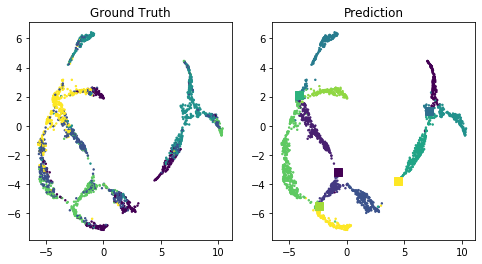

Start of epoch 251
70/70 [==============================] - 8s 117ms/step - loss_neg_E_nb: 387.7420 - loss_neg_E_pz: 42.9770 - loss_E_qzx   : 1.3207 - loss_total: 425.3754
 Training loss over epoch: 426.3258972167969
 382.303772,  42.696217,  1.325886
Start of epoch 252
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 395.5978 - loss_neg_E_pz: 43.6225 - loss_E_qzx   : 0.9803 - loss_total: 423.3926
 Training loss over epoch: 426.7961120605469
 383.032074,  42.716370,  1.047583
Start of epoch 253
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 366.2837 - loss_neg_E_pz: 41.4942 - loss_E_qzx   : 0.9164 - loss_total: 425.8444
 Training loss over epoch: 425.4083251953125
 381.561279,  42.579472,  1.267653
Start of epoch 254
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 384.2547 - loss_neg_E_pz: 41.8928 - loss_E_qzx   : 1.3316 - loss_total: 424.1511
 Training loss over epoch: 425.96014404296875
 382.054443,  42.638142,  

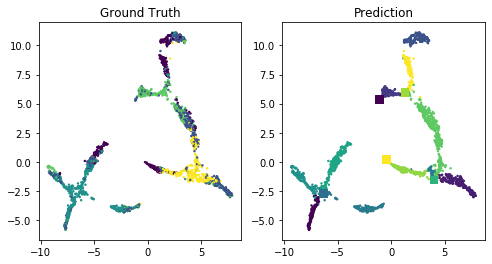

Start of epoch 261
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 349.7787 - loss_neg_E_pz: 42.2185 - loss_E_qzx   : 0.7807 - loss_total: 424.3751
 Training loss over epoch: 424.3868713378906
 380.956696,  42.334572,  1.095463
Start of epoch 262
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 390.1875 - loss_neg_E_pz: 43.1563 - loss_E_qzx   : 1.5947 - loss_total: 425.4545
 Training loss over epoch: 425.15509033203125
 381.374146,  42.420040,  1.360997
Start of epoch 263
70/70 [==============================] - 8s 114ms/step - loss_neg_E_nb: 396.3166 - loss_neg_E_pz: 42.1807 - loss_E_qzx   : 1.5255 - loss_total: 420.9277
 Training loss over epoch: 425.25341796875
 381.784607,  42.265728,  1.203114
Start of epoch 264
70/70 [==============================] - 8s 114ms/step - loss_neg_E_nb: 397.5588 - loss_neg_E_pz: 42.7454 - loss_E_qzx   : 1.5812 - loss_total: 426.0440
 Training loss over epoch: 424.66241455078125
 380.929718,  42.322662,  1

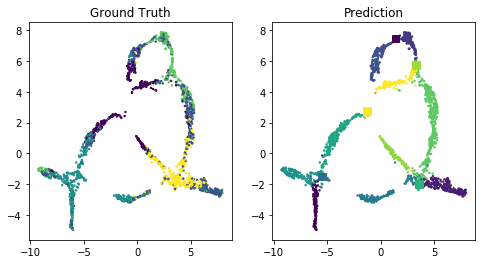

Start of epoch 271
70/70 [==============================] - 8s 114ms/step - loss_neg_E_nb: 400.0624 - loss_neg_E_pz: 41.9322 - loss_E_qzx   : 1.6226 - loss_total: 418.5159
 Training loss over epoch: 425.0208740234375
 381.446686,  42.061543,  1.512513
Start of epoch 272
70/70 [==============================] - 8s 116ms/step - loss_neg_E_nb: 363.2378 - loss_neg_E_pz: 42.4662 - loss_E_qzx   : 1.2279 - loss_total: 426.3778
 Training loss over epoch: 423.93963623046875
 380.479645,  42.074944,  1.385052
Start of epoch 273
70/70 [==============================] - 9s 122ms/step - loss_neg_E_nb: 397.8236 - loss_neg_E_pz: 42.7412 - loss_E_qzx   : 1.6951 - loss_total: 424.7186
 Training loss over epoch: 424.5245361328125
 381.072876,  42.071560,  1.380234
Start of epoch 274
70/70 [==============================] - 8s 117ms/step - loss_neg_E_nb: 379.2893 - loss_neg_E_pz: 41.6534 - loss_E_qzx   : 1.4892 - loss_total: 423.5577
 Training loss over epoch: 423.57586669921875
 380.173706,  41.944653, 

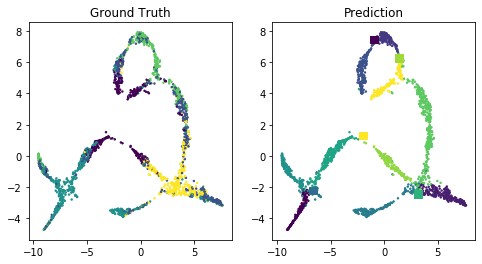

Start of epoch 281
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 382.5612 - loss_neg_E_pz: 41.8122 - loss_E_qzx   : 2.0037 - loss_total: 418.6897
 Training loss over epoch: 423.00579833984375
 379.450958,  41.834377,  1.720407
Start of epoch 282
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 378.8076 - loss_neg_E_pz: 41.9578 - loss_E_qzx   : 1.6642 - loss_total: 419.3027
 Training loss over epoch: 422.73114013671875
 379.352051,  41.801796,  1.577308
Start of epoch 283
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 382.2551 - loss_neg_E_pz: 42.0322 - loss_E_qzx   : 1.6344 - loss_total: 424.2765
 Training loss over epoch: 423.2038879394531
 379.790222,  41.771194,  1.642578
Start of epoch 284
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 386.8344 - loss_neg_E_pz: 42.1222 - loss_E_qzx   : 1.9504 - loss_total: 421.0740
 Training loss over epoch: 423.0724182128906
 379.530334,  41.776852, 

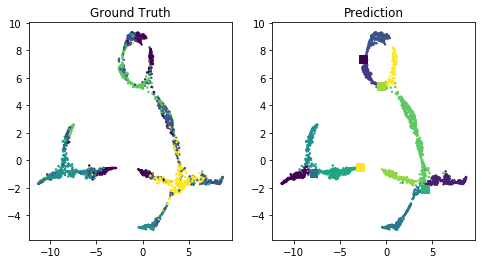

Start of epoch 291
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 390.3236 - loss_neg_E_pz: 42.1189 - loss_E_qzx   : 1.8734 - loss_total: 421.3711
 Training loss over epoch: 421.9685974121094
 378.568451,  41.574612,  1.825494
Start of epoch 292
70/70 [==============================] - 8s 114ms/step - loss_neg_E_nb: 390.1349 - loss_neg_E_pz: 42.1990 - loss_E_qzx   : 1.9208 - loss_total: 421.7762
 Training loss over epoch: 421.7547607421875
 378.505341,  41.571465,  1.678096
Start of epoch 293
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 382.2702 - loss_neg_E_pz: 40.6451 - loss_E_qzx   : 1.5999 - loss_total: 422.1269
 Training loss over epoch: 422.1219177246094
 378.819672,  41.470875,  1.831343
Start of epoch 294
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 379.3956 - loss_neg_E_pz: 41.7115 - loss_E_qzx   : 1.8250 - loss_total: 425.4504
 Training loss over epoch: 421.7694091796875
 378.417725,  41.477894,  1

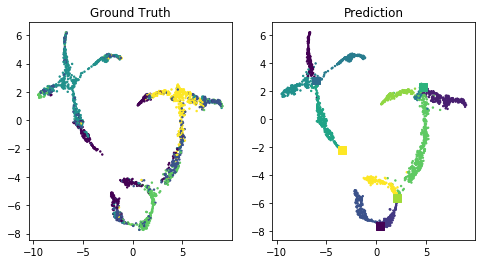

Start of epoch 301
70/70 [==============================] - 7s 104ms/step - loss_neg_E_nb: 377.7216 - loss_neg_E_pz: 40.6916 - loss_E_qzx   : 2.0264 - loss_total: 421.7481
 Training loss over epoch: 421.0691833496094
 377.694763,  41.310532,  2.063854
Start of epoch 302
70/70 [==============================] - 7s 104ms/step - loss_neg_E_nb: 376.8138 - loss_neg_E_pz: 42.6546 - loss_E_qzx   : 1.8212 - loss_total: 423.0524
 Training loss over epoch: 420.7541809082031
 377.552429,  41.309948,  1.891837
Start of epoch 303
70/70 [==============================] - 7s 104ms/step - loss_neg_E_nb: 357.7494 - loss_neg_E_pz: 39.8616 - loss_E_qzx   : 1.5396 - loss_total: 419.2691
 Training loss over epoch: 420.4744567871094
 377.287292,  41.291481,  1.895736
Start of epoch 304
70/70 [==============================] - 8s 108ms/step - loss_neg_E_nb: 375.4955 - loss_neg_E_pz: 40.8613 - loss_E_qzx   : 2.0486 - loss_total: 419.2712
 Training loss over epoch: 420.80120849609375
 377.559265,  41.314407,  

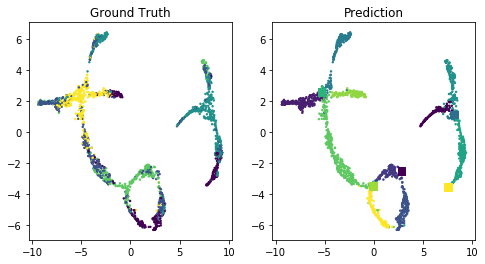

Start of epoch 311
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 368.5121 - loss_neg_E_pz: 40.3042 - loss_E_qzx   : 2.2960 - loss_total: 422.9426
 Training loss over epoch: 420.38714599609375
 377.058350,  41.067909,  2.260995
Start of epoch 312
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 378.3034 - loss_neg_E_pz: 41.1460 - loss_E_qzx   : 2.0807 - loss_total: 420.1183
 Training loss over epoch: 420.57440185546875
 377.451996,  41.024124,  2.098316
Start of epoch 313
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 399.7369 - loss_neg_E_pz: 39.8425 - loss_E_qzx   : 2.1556 - loss_total: 420.4525
 Training loss over epoch: 420.92779541015625
 377.863739,  40.993675,  2.070414
Start of epoch 314
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 381.7987 - loss_neg_E_pz: 40.2525 - loss_E_qzx   : 2.1264 - loss_total: 416.1111
 Training loss over epoch: 420.30181884765625
 377.065918,  41.062672

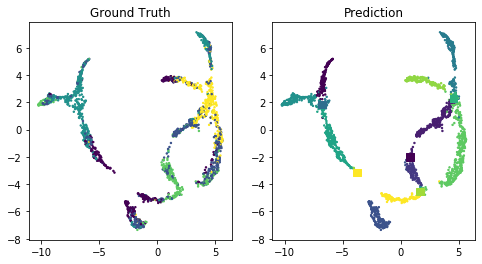

Start of epoch 321
70/70 [==============================] - 8s 115ms/step - loss_neg_E_nb: 369.5131 - loss_neg_E_pz: 41.1828 - loss_E_qzx   : 2.0626 - loss_total: 420.3683
 Training loss over epoch: 419.5113830566406
 376.330719,  40.845646,  2.334975
Start of epoch 322
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 371.8967 - loss_neg_E_pz: 40.5706 - loss_E_qzx   : 2.3732 - loss_total: 419.8969
 Training loss over epoch: 419.6298522949219
 376.358582,  40.832581,  2.438753
Start of epoch 323
70/70 [==============================] - 8s 116ms/step - loss_neg_E_nb: 378.1708 - loss_neg_E_pz: 39.4109 - loss_E_qzx   : 2.1390 - loss_total: 419.3580
 Training loss over epoch: 419.7501525878906
 376.661377,  40.764603,  2.324269
Start of epoch 324
70/70 [==============================] - 8s 117ms/step - loss_neg_E_nb: 381.1839 - loss_neg_E_pz: 41.4151 - loss_E_qzx   : 2.3534 - loss_total: 420.5927
 Training loss over epoch: 420.2254333496094
 376.979340,  40.886307,  2

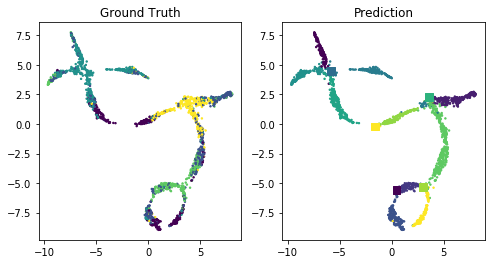

Start of epoch 331
70/70 [==============================] - 8s 118ms/step - loss_neg_E_nb: 378.7916 - loss_neg_E_pz: 41.0226 - loss_E_qzx   : 2.3103 - loss_total: 416.2470
 Training loss over epoch: 419.27703857421875
 376.168121,  40.691525,  2.417307
Start of epoch 332
70/70 [==============================] - 9s 123ms/step - loss_neg_E_nb: 388.8804 - loss_neg_E_pz: 40.0897 - loss_E_qzx   : 2.4103 - loss_total: 422.2596
 Training loss over epoch: 419.3563537597656
 376.312836,  40.579166,  2.464219
Start of epoch 333
70/70 [==============================] - 8s 120ms/step - loss_neg_E_nb: 376.4013 - loss_neg_E_pz: 39.4261 - loss_E_qzx   : 2.4881 - loss_total: 420.5197
 Training loss over epoch: 418.9355163574219
 375.886780,  40.530659,  2.518122
Start of epoch 334
70/70 [==============================] - 8s 119ms/step - loss_neg_E_nb: 381.3867 - loss_neg_E_pz: 41.5654 - loss_E_qzx   : 2.9907 - loss_total: 422.3542
 Training loss over epoch: 419.0664978027344
 375.814758,  40.531227,  

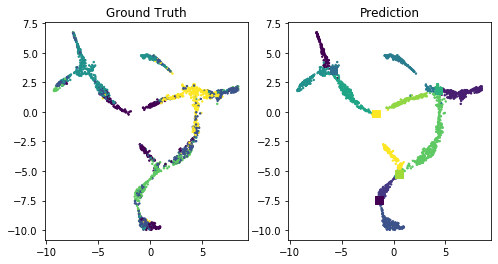

Start of epoch 341
70/70 [==============================] - 8s 117ms/step - loss_neg_E_nb: 379.1669 - loss_neg_E_pz: 40.8771 - loss_E_qzx   : 2.6542 - loss_total: 421.4968
 Training loss over epoch: 417.97259521484375
 374.863342,  40.440254,  2.668971
Start of epoch 342
70/70 [==============================] - 8s 114ms/step - loss_neg_E_nb: 374.5736 - loss_neg_E_pz: 40.4134 - loss_E_qzx   : 2.6561 - loss_total: 419.1583
 Training loss over epoch: 418.0097961425781
 374.905457,  40.448009,  2.656361
Start of epoch 343
70/70 [==============================] - 8s 119ms/step - loss_neg_E_nb: 358.7958 - loss_neg_E_pz: 39.3265 - loss_E_qzx   : 2.5482 - loss_total: 419.3144
 Training loss over epoch: 418.01458740234375
 375.102905,  40.328247,  2.583529
Start of epoch 344
70/70 [==============================] - 9s 124ms/step - loss_neg_E_nb: 367.4910 - loss_neg_E_pz: 40.0970 - loss_E_qzx   : 2.8157 - loss_total: 416.2188
 Training loss over epoch: 418.9525146484375
 375.883698,  40.372353, 

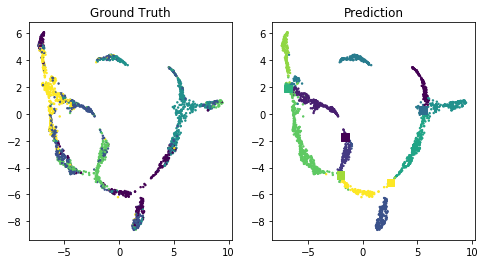

Start of epoch 351
70/70 [==============================] - 9s 123ms/step - loss_neg_E_nb: 383.8211 - loss_neg_E_pz: 39.3123 - loss_E_qzx   : 3.0615 - loss_total: 416.0828
 Training loss over epoch: 418.5697021484375
 375.558716,  40.136570,  2.874547
Start of epoch 352
70/70 [==============================] - 8s 121ms/step - loss_neg_E_nb: 385.6035 - loss_neg_E_pz: 39.5684 - loss_E_qzx   : 2.9272 - loss_total: 414.4971
 Training loss over epoch: 418.031494140625
 374.935364,  40.274799,  2.821239
Start of epoch 353
70/70 [==============================] - 8s 121ms/step - loss_neg_E_nb: 389.3861 - loss_neg_E_pz: 40.1572 - loss_E_qzx   : 2.9564 - loss_total: 417.7713
 Training loss over epoch: 417.0634460449219
 374.272705,  40.122894,  2.667970
Start of epoch 354
70/70 [==============================] - 10s 138ms/step - loss_neg_E_nb: 362.0836 - loss_neg_E_pz: 40.1457 - loss_E_qzx   : 2.6583 - loss_total: 416.6147
 Training loss over epoch: 416.9012145996094
 373.938293,  40.180313,  2

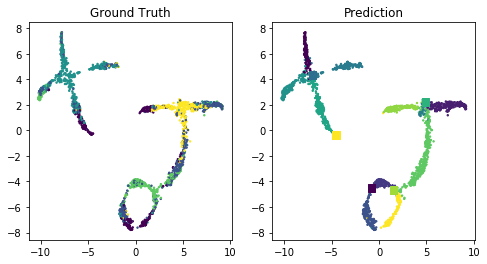

Start of epoch 361
70/70 [==============================] - 9s 123ms/step - loss_neg_E_nb: 371.0874 - loss_neg_E_pz: 40.5401 - loss_E_qzx   : 2.6644 - loss_total: 419.3103
 Training loss over epoch: 416.8402404785156
 373.996552,  40.068958,  2.774707
Start of epoch 362
70/70 [==============================] - 9s 126ms/step - loss_neg_E_nb: 368.8486 - loss_neg_E_pz: 39.8172 - loss_E_qzx   : 2.9679 - loss_total: 417.1190
 Training loss over epoch: 416.8806457519531
 373.983185,  40.063622,  2.833795
Start of epoch 363
70/70 [==============================] - 9s 129ms/step - loss_neg_E_nb: 367.0890 - loss_neg_E_pz: 39.3387 - loss_E_qzx   : 2.8303 - loss_total: 415.7788
 Training loss over epoch: 417.97039794921875
 374.936310,  40.010887,  3.023244
Start of epoch 364
70/70 [==============================] - 9s 124ms/step - loss_neg_E_nb: 388.1589 - loss_neg_E_pz: 38.6392 - loss_E_qzx   : 3.1127 - loss_total: 417.4437
 Training loss over epoch: 417.1107177734375
 374.152588,  39.994659,  

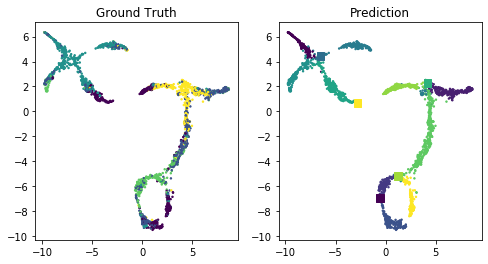

Start of epoch 371
70/70 [==============================] - 9s 126ms/step - loss_neg_E_nb: 384.3755 - loss_neg_E_pz: 39.9734 - loss_E_qzx   : 3.3445 - loss_total: 419.0079
 Training loss over epoch: 416.63348388671875
 373.661957,  39.835861,  3.135631
Start of epoch 372
70/70 [==============================] - 9s 128ms/step - loss_neg_E_nb: 365.4059 - loss_neg_E_pz: 39.3793 - loss_E_qzx   : 3.0716 - loss_total: 420.7002
 Training loss over epoch: 415.5474548339844
 372.636230,  39.819561,  3.091697
Start of epoch 373
70/70 [==============================] - 9s 122ms/step - loss_neg_E_nb: 370.2173 - loss_neg_E_pz: 39.2874 - loss_E_qzx   : 3.0603 - loss_total: 415.7878
 Training loss over epoch: 416.3162536621094
 373.480255,  39.870556,  2.965359
Start of epoch 374
70/70 [==============================] - 9s 123ms/step - loss_neg_E_nb: 367.8472 - loss_neg_E_pz: 39.7104 - loss_E_qzx   : 3.4002 - loss_total: 414.4514
 Training loss over epoch: 415.7979736328125
 372.896820,  39.758469,  

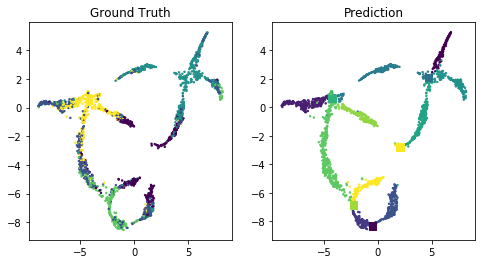

Start of epoch 381
70/70 [==============================] - 8s 121ms/step - loss_neg_E_nb: 373.9629 - loss_neg_E_pz: 40.5902 - loss_E_qzx   : 3.1882 - loss_total: 413.5303
 Training loss over epoch: 415.6424865722656
 372.793396,  39.731144,  3.118020
Start of epoch 382
70/70 [==============================] - 9s 122ms/step - loss_neg_E_nb: 387.3589 - loss_neg_E_pz: 40.3490 - loss_E_qzx   : 3.5578 - loss_total: 416.3364
 Training loss over epoch: 415.9012756347656
 373.011871,  39.669376,  3.220038
Start of epoch 383
70/70 [==============================] - 8s 120ms/step - loss_neg_E_nb: 367.9610 - loss_neg_E_pz: 39.9408 - loss_E_qzx   : 3.1632 - loss_total: 417.6630
 Training loss over epoch: 415.52728271484375
 372.491394,  39.664085,  3.371799
Start of epoch 384
70/70 [==============================] - 8s 120ms/step - loss_neg_E_nb: 377.7239 - loss_neg_E_pz: 40.7961 - loss_E_qzx   : 3.3594 - loss_total: 412.4954
 Training loss over epoch: 415.3058166503906
 372.455627,  39.586140,  

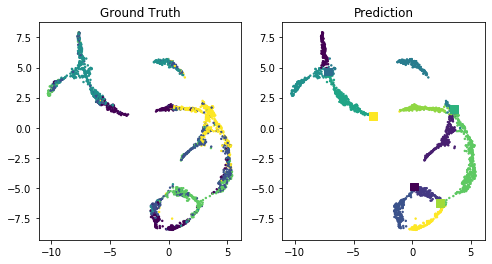

Start of epoch 391
70/70 [==============================] - 8s 120ms/step - loss_neg_E_nb: 384.5835 - loss_neg_E_pz: 38.4319 - loss_E_qzx   : 3.6018 - loss_total: 413.7126
 Training loss over epoch: 415.4386291503906
 372.562439,  39.467396,  3.408898
Start of epoch 392
70/70 [==============================] - 8s 119ms/step - loss_neg_E_nb: 378.9231 - loss_neg_E_pz: 39.1459 - loss_E_qzx   : 3.4220 - loss_total: 413.7767
 Training loss over epoch: 415.61822509765625
 372.720795,  39.474777,  3.422672
Start of epoch 393
70/70 [==============================] - 8s 120ms/step - loss_neg_E_nb: 380.9785 - loss_neg_E_pz: 39.3348 - loss_E_qzx   : 3.2847 - loss_total: 416.3372
 Training loss over epoch: 414.9239196777344
 372.068390,  39.487446,  3.368228
Start of epoch 394
70/70 [==============================] - 8s 121ms/step - loss_neg_E_nb: 375.6195 - loss_neg_E_pz: 38.0981 - loss_E_qzx   : 3.1303 - loss_total: 413.6139
 Training loss over epoch: 415.3078918457031
 372.605988,  39.449841,  

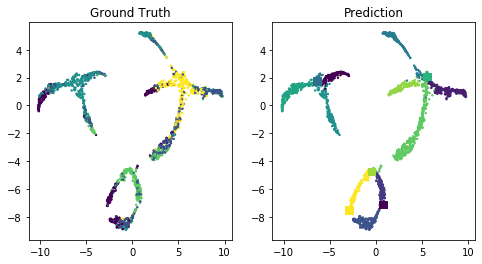

Start of epoch 401
70/70 [==============================] - 9s 122ms/step - loss_neg_E_nb: 382.2289 - loss_neg_E_pz: 38.9025 - loss_E_qzx   : 3.5718 - loss_total: 418.6620
 Training loss over epoch: 413.9584045410156
 371.165100,  39.318169,  3.475137
Start of epoch 402
70/70 [==============================] - 8s 121ms/step - loss_neg_E_nb: 363.8980 - loss_neg_E_pz: 39.3120 - loss_E_qzx   : 3.1706 - loss_total: 414.4123
 Training loss over epoch: 414.70703125
 372.045837,  39.360661,  3.300676
Start of epoch 403
70/70 [==============================] - 8s 117ms/step - loss_neg_E_nb: 378.3076 - loss_neg_E_pz: 40.0360 - loss_E_qzx   : 3.4003 - loss_total: 416.1750
 Training loss over epoch: 415.210205078125
 372.443512,  39.339531,  3.427135
Start of epoch 404
70/70 [==============================] - 9s 128ms/step - loss_neg_E_nb: 394.1666 - loss_neg_E_pz: 39.1722 - loss_E_qzx   : 3.7442 - loss_total: 412.1236
 Training loss over epoch: 415.7272033691406
 372.848846,  39.257893,  3.62046

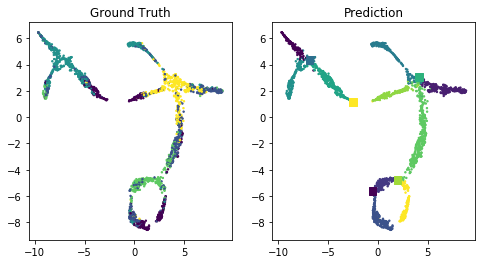

Start of epoch 411
70/70 [==============================] - 8s 120ms/step - loss_neg_E_nb: 361.8056 - loss_neg_E_pz: 39.5425 - loss_E_qzx   : 3.5345 - loss_total: 414.7671
 Training loss over epoch: 413.7725830078125
 370.982086,  39.162964,  3.627446
Start of epoch 412
70/70 [==============================] - 8s 120ms/step - loss_neg_E_nb: 375.5753 - loss_neg_E_pz: 40.0114 - loss_E_qzx   : 3.9183 - loss_total: 414.8303
 Training loss over epoch: 414.3003234863281
 371.465912,  39.193207,  3.641080
Start of epoch 413
70/70 [==============================] - 9s 122ms/step - loss_neg_E_nb: 369.3516 - loss_neg_E_pz: 39.0685 - loss_E_qzx   : 3.5589 - loss_total: 414.5274
 Training loss over epoch: 413.7264099121094
 370.811157,  39.137043,  3.778170
Start of epoch 414
70/70 [==============================] - 9s 122ms/step - loss_neg_E_nb: 386.9980 - loss_neg_E_pz: 40.1211 - loss_E_qzx   : 3.9851 - loss_total: 414.4163
 Training loss over epoch: 414.11865234375
 371.206909,  39.138779,  3.7

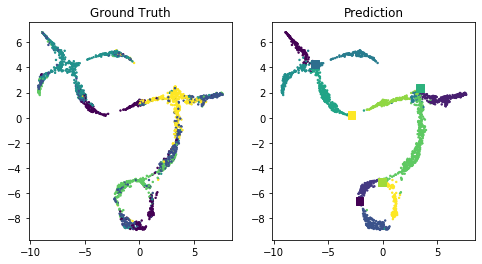

Start of epoch 421
70/70 [==============================] - 8s 121ms/step - loss_neg_E_nb: 363.8201 - loss_neg_E_pz: 38.6818 - loss_E_qzx   : 3.6279 - loss_total: 411.5306
 Training loss over epoch: 413.1261901855469
 370.368805,  39.024403,  3.733016
Start of epoch 422
70/70 [==============================] - 8s 120ms/step - loss_neg_E_nb: 360.9645 - loss_neg_E_pz: 39.3516 - loss_E_qzx   : 3.6635 - loss_total: 417.5719
 Training loss over epoch: 413.46002197265625
 370.603088,  39.007256,  3.849579
Start of epoch 423
70/70 [==============================] - 8s 119ms/step - loss_neg_E_nb: 365.9616 - loss_neg_E_pz: 38.5119 - loss_E_qzx   : 3.7968 - loss_total: 411.9096
 Training loss over epoch: 413.70263671875
 370.902405,  38.951939,  3.848407
Start of epoch 424
70/70 [==============================] - 8s 118ms/step - loss_neg_E_nb: 373.7887 - loss_neg_E_pz: 38.9223 - loss_E_qzx   : 4.2237 - loss_total: 414.8809
 Training loss over epoch: 413.43096923828125
 370.605988,  38.963116,  3

In [0]:
# ---------------------------------------------------------------------------- #
# Training together.
# ---------------------------------------------------------------------------- #
optimizer = tf.keras.optimizers.Adam(1e-4)
loss_total = tf.keras.metrics.Mean()
loss_neg_E_nb = tf.keras.metrics.Mean()
loss_neg_E_pz = tf.keras.metrics.Mean()
loss_E_qzx = tf.keras.metrics.Mean()
early_stopping = Early_Stopping(patience=10, tolerance=1e-4)
for epoch in range(NUM_EPOCH):
    print('Start of epoch %d' % (epoch,))
    progbar = Progbar(NUM_STEP_PER_EPOCH)
    
    # Iterate over the batches of the dataset.
    for step, (x_batch, x_norm_batch, x_scale_factor) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae(x_norm_batch, x_batch, x_scale_factor)
            loss = tf.reduce_sum(vae.losses)  

        grads = tape.gradient(loss, vae.trainable_weights,
                              unconnected_gradients=tf.UnconnectedGradients.ZERO)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))
        #vae.GMM.normalize()
        loss_total(loss)
        loss_neg_E_nb(vae.losses[0])
        loss_neg_E_pz(vae.losses[1])
        loss_E_qzx(vae.losses[2])

        if (step+1)%10==0 or step+1==NUM_STEP_PER_EPOCH:
            progbar.update(step+1, [
                    ('loss_neg_E_nb'    ,   float(vae.losses[0])),
                    ('loss_neg_E_pz'    ,   float(vae.losses[1])),
                    ('loss_E_qzx   '    ,   float(vae.losses[2])),
                    ('loss_total'       ,   float(loss_total.result()))
                    ])
    
    if early_stopping(float(loss_total.result())):
        print('Early stopping.')
        break
    print(' Training loss over epoch: %s' % (float(loss_total.result())))  
    print('% 4.6f, % 4.6f, % 4.6f' % (float(loss_neg_E_nb.result()),
                                      float(loss_neg_E_pz.result()),
                                      float(loss_E_qzx.result())))
    loss_total.reset_states()
    loss_neg_E_nb.reset_states()
    loss_neg_E_pz.reset_states()
    loss_E_qzx.reset_states()

    if epoch%10==0 or epoch==NUM_EPOCH-1:        
        pi,mu,c,w,var_w,z,proj_z = vae(X_normalized, inference=True)

        fit = umap.UMAP()
        uz = fit.fit_transform(z)
        u = fit.transform(mu.numpy().T)

        plt.figure(figsize=(8,4))
        ax = plt.subplot(121)
        plt.scatter(uz[:,0], uz[:,1], c=y, s=2)
        ax.set_title('Ground Truth')

        ax = plt.subplot(122)
        scatter = plt.scatter(uz[:,0], uz[:,1], c=c, s=2)
        ax.set_title('Prediction')        
        # legend1 = ax.legend(*scatter.legend_elements(),
        #                     loc="lower left", title="Classes")
        # ax.add_artist(legend1)
        cluster_center = [(NUM_CLUSTER+(1-i)/2)*i for i in range(NUM_CLUSTER)]        
        plt.scatter(u[:,0], u[:,1], c=cluster_center, s=60, marker='s')
        plt.savefig('/content/drive/My Drive/Data/%d.png'%epoch, dpi=300)
        plt.show()
        vae.save_weights('/content/drive/My Drive/Data/train.checkpoint')        

## Training with clustering loss

Start of epoch 0
70/70 [==============================] - 9s 130ms/step - loss_neg_E_nb: 266.2826 - loss_neg_E_pz: 551.3199 - loss_E_qzx   : 272.3062
 Training loss over epoch: 1145.0279541015625
 284.998962,  571.884705,  288.144135,  0.919387


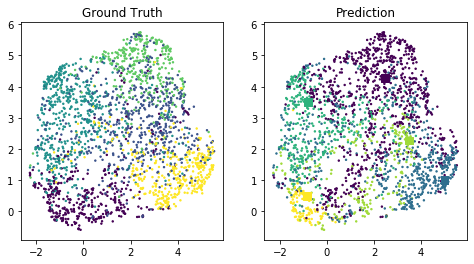

Start of epoch 1
70/70 [==============================] - 9s 125ms/step - loss_neg_E_nb: 302.3147 - loss_neg_E_pz: 411.9956 - loss_E_qzx   : 201.1977
 Training loss over epoch: 949.95947265625
 303.648926,  435.367554,  210.943100,  0.908570
Start of epoch 2
70/70 [==============================] - 9s 124ms/step - loss_neg_E_nb: 326.7227 - loss_neg_E_pz: 343.0946 - loss_E_qzx   : 167.3396
 Training loss over epoch: 841.3073120117188
 318.800873,  354.682007,  167.824509,  0.901780
Start of epoch 3
70/70 [==============================] - 9s 125ms/step - loss_neg_E_nb: 324.3697 - loss_neg_E_pz: 294.7539 - loss_E_qzx   : 140.9441
 Training loss over epoch: 768.5907592773438
 329.687347,  299.620728,  139.282745,  0.892737
Start of epoch 4
70/70 [==============================] - 9s 125ms/step - loss_neg_E_nb: 328.3075 - loss_neg_E_pz: 247.9689 - loss_E_qzx   : 118.1909
 Training loss over epoch: 711.6004638671875
 335.046875,  257.435394,  119.118279,  0.883014
Start of epoch 5
70/70 [==

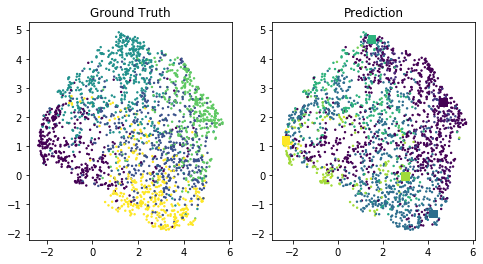

Start of epoch 11
70/70 [==============================] - 9s 130ms/step - loss_neg_E_nb: 350.2988 - loss_neg_E_pz: 143.8295 - loss_E_qzx   : 49.1201
 Training loss over epoch: 538.6243286132812
 349.994202,  138.193558,  50.436466,  0.841341
Start of epoch 12
70/70 [==============================] - 9s 130ms/step - loss_neg_E_nb: 348.0011 - loss_neg_E_pz: 120.1867 - loss_E_qzx   : 48.6007
 Training loss over epoch: 525.5302124023438
 349.568848,  129.885193,  46.076149,  0.835005
Start of epoch 13
70/70 [==============================] - 9s 128ms/step - loss_neg_E_nb: 340.8271 - loss_neg_E_pz: 120.7716 - loss_E_qzx   : 39.1390
 Training loss over epoch: 514.4376831054688
 349.664581,  123.581108,  41.192036,  0.835021
Start of epoch 14
70/70 [==============================] - 9s 129ms/step - loss_neg_E_nb: 333.1278 - loss_neg_E_pz: 111.7630 - loss_E_qzx   : 36.7271
 Training loss over epoch: 505.989501953125
 350.501831,  117.615944,  37.871700,  0.831191
Start of epoch 15
70/70 [====

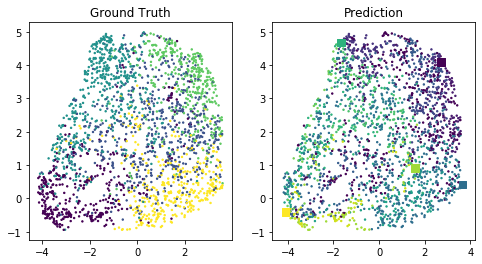

Start of epoch 21
70/70 [==============================] - 9s 127ms/step - loss_neg_E_nb: 328.2388 - loss_neg_E_pz: 88.8443 - loss_E_qzx   : 23.6445
 Training loss over epoch: 462.4046630859375
 350.002747,  90.364746,  22.037186,  0.813572
Start of epoch 22
70/70 [==============================] - 9s 127ms/step - loss_neg_E_nb: 354.5136 - loss_neg_E_pz: 89.8245 - loss_E_qzx   : 20.1768
 Training loss over epoch: 458.0755310058594
 349.505951,  87.720535,  20.848995,  0.809933
Start of epoch 23
70/70 [==============================] - 10s 136ms/step - loss_neg_E_nb: 341.3800 - loss_neg_E_pz: 86.7071 - loss_E_qzx   : 19.0339
 Training loss over epoch: 453.56121826171875
 349.093262,  85.802483,  18.665428,  0.808802
Start of epoch 24
70/70 [==============================] - 9s 128ms/step - loss_neg_E_nb: 362.9770 - loss_neg_E_pz: 82.6696 - loss_E_qzx   : 18.6112
 Training loss over epoch: 451.1054992675781
 349.512512,  83.399185,  18.193848,  0.804010
Start of epoch 25
70/70 [=========

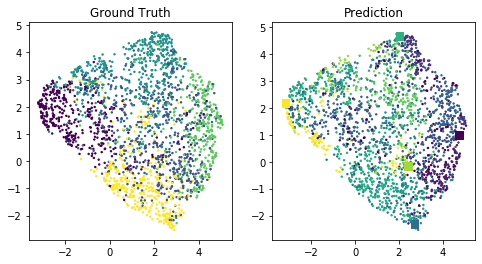

Start of epoch 31
70/70 [==============================] - 9s 128ms/step - loss_neg_E_nb: 339.3982 - loss_neg_E_pz: 70.3655 - loss_E_qzx   : 13.2638
 Training loss over epoch: 431.9494323730469
 346.895355,  72.440117,  12.613944,  0.792721
Start of epoch 32
70/70 [==============================] - 9s 126ms/step - loss_neg_E_nb: 333.1372 - loss_neg_E_pz: 67.1023 - loss_E_qzx   : 9.7394
 Training loss over epoch: 429.0221252441406
 346.378632,  71.139679,  11.503906,  0.794816
Start of epoch 33
70/70 [==============================] - 9s 122ms/step - loss_neg_E_nb: 339.2612 - loss_neg_E_pz: 70.8512 - loss_E_qzx   : 11.7389
 Training loss over epoch: 426.6834411621094
 345.727570,  70.064346,  10.891555,  0.791206
Start of epoch 34
70/70 [==============================] - 8s 121ms/step - loss_neg_E_nb: 344.5619 - loss_neg_E_pz: 69.9436 - loss_E_qzx   : 11.0545
 Training loss over epoch: 425.0631408691406
 345.249573,  69.160217,  10.653397,  0.785137
Start of epoch 35
70/70 [============

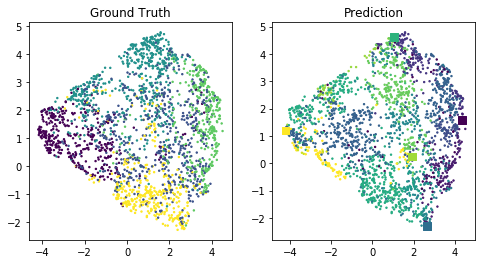

Start of epoch 41
70/70 [==============================] - 9s 124ms/step - loss_neg_E_nb: 335.8622 - loss_neg_E_pz: 61.2955 - loss_E_qzx   : 8.2049
 Training loss over epoch: 413.66326904296875
 342.986816,  63.196911,  7.479452,  0.777168
Start of epoch 42
70/70 [==============================] - 9s 123ms/step - loss_neg_E_nb: 329.3967 - loss_neg_E_pz: 61.0413 - loss_E_qzx   : 7.4385
 Training loss over epoch: 412.2001037597656
 342.683502,  62.514587,  7.002169,  0.777243
Start of epoch 43
70/70 [==============================] - 9s 123ms/step - loss_neg_E_nb: 336.7874 - loss_neg_E_pz: 62.8520 - loss_E_qzx   : 6.8402
 Training loss over epoch: 410.7423095703125
 341.985748,  61.837257,  6.919313,  0.776641
Start of epoch 44
70/70 [==============================] - 9s 126ms/step - loss_neg_E_nb: 336.7937 - loss_neg_E_pz: 60.2583 - loss_E_qzx   : 4.4957
 Training loss over epoch: 409.31365966796875
 341.624084,  61.449043,  6.240582,  0.775016
Start of epoch 45
70/70 [=================

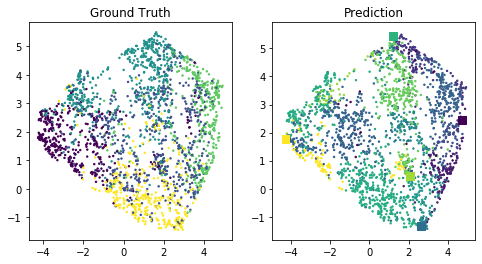

Start of epoch 51
70/70 [==============================] - 9s 127ms/step - loss_neg_E_nb: 326.9511 - loss_neg_E_pz: 58.7708 - loss_E_qzx   : 3.1591
 Training loss over epoch: 401.0727233886719
 338.947235,  57.616867,  4.508539,  0.769102
Start of epoch 52
70/70 [==============================] - 9s 123ms/step - loss_neg_E_nb: 344.2253 - loss_neg_E_pz: 57.4729 - loss_E_qzx   : 4.9908
 Training loss over epoch: 401.03033447265625
 339.305664,  57.250298,  4.474340,  0.766824
Start of epoch 53
70/70 [==============================] - 9s 123ms/step - loss_neg_E_nb: 343.4448 - loss_neg_E_pz: 55.3532 - loss_E_qzx   : 5.6754
 Training loss over epoch: 400.12835693359375
 338.827911,  56.910355,  4.390070,  0.769526
Start of epoch 54
70/70 [==============================] - 9s 126ms/step - loss_neg_E_nb: 333.4822 - loss_neg_E_pz: 58.6751 - loss_E_qzx   : 4.5004
 Training loss over epoch: 398.606689453125
 338.328491,  56.466385,  3.811845,  0.763816
Start of epoch 55
70/70 [==================

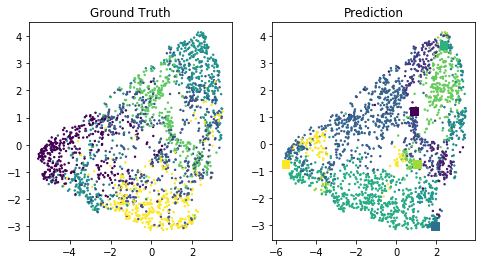

Start of epoch 61
70/70 [==============================] - 8s 120ms/step - loss_neg_E_nb: 317.1672 - loss_neg_E_pz: 52.8370 - loss_E_qzx   : 2.6219
 Training loss over epoch: 392.20196533203125
 335.280334,  54.068069,  2.853548,  0.758358
Start of epoch 62
70/70 [==============================] - 9s 124ms/step - loss_neg_E_nb: 348.4595 - loss_neg_E_pz: 54.8396 - loss_E_qzx   : 2.5653
 Training loss over epoch: 391.947021484375
 335.276764,  53.864143,  2.806154,  0.753865
Start of epoch 63
70/70 [==============================] - 9s 131ms/step - loss_neg_E_nb: 331.7298 - loss_neg_E_pz: 51.8253 - loss_E_qzx   : 2.0322
 Training loss over epoch: 391.1107177734375
 335.090881,  53.504192,  2.515543,  0.757052
Start of epoch 64
70/70 [==============================] - 8s 120ms/step - loss_neg_E_nb: 323.6940 - loss_neg_E_pz: 52.4234 - loss_E_qzx   : 2.2951
 Training loss over epoch: 390.5047302246094
 334.886841,  53.121555,  2.496396,  0.754556
Start of epoch 65
70/70 [===================

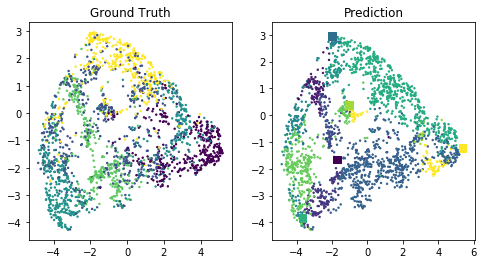

Start of epoch 71
70/70 [==============================] - 8s 118ms/step - loss_neg_E_nb: 332.7906 - loss_neg_E_pz: 51.9028 - loss_E_qzx   : 1.2183
 Training loss over epoch: 384.8730163574219
 332.176270,  51.468250,  1.228397,  0.749819
Start of epoch 72
70/70 [==============================] - 8s 121ms/step - loss_neg_E_nb: 353.8316 - loss_neg_E_pz: 50.7235 - loss_E_qzx   : 1.4740
 Training loss over epoch: 384.5409240722656
 332.195160,  51.095287,  1.250470,  0.752680
Start of epoch 73
70/70 [==============================] - 9s 122ms/step - loss_neg_E_nb: 314.9928 - loss_neg_E_pz: 49.0125 - loss_E_qzx   : 2.1175
 Training loss over epoch: 383.45721435546875
 331.348755,  50.834454,  1.274055,  0.747036
Start of epoch 74
70/70 [==============================] - 8s 120ms/step - loss_neg_E_nb: 331.4120 - loss_neg_E_pz: 49.2031 - loss_E_qzx   : 0.9966
 Training loss over epoch: 383.41522216796875
 331.557587,  50.653339,  1.204260,  0.749486
Start of epoch 75
70/70 [=================

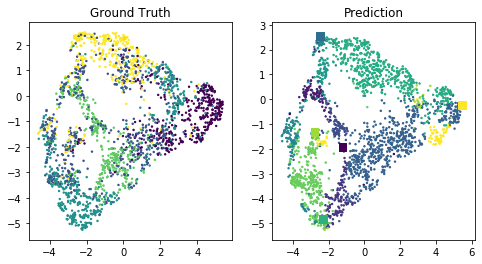

Start of epoch 81
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 327.6017 - loss_neg_E_pz: 48.8754 - loss_E_qzx   : 1.2340
 Training loss over epoch: 379.1785888671875
 329.341827,  49.161064,  0.675782,  0.744983
Start of epoch 82
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 315.9736 - loss_neg_E_pz: 48.6053 - loss_E_qzx   : 0.4582
 Training loss over epoch: 379.0083312988281
 329.333099,  49.036297,  0.638881,  0.743427
Start of epoch 83
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 326.9732 - loss_neg_E_pz: 48.4211 - loss_E_qzx   : -0.1620
 Training loss over epoch: 378.6426086425781
 329.312439,  48.853458,  0.476775,  0.746012
Start of epoch 84
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 331.1099 - loss_neg_E_pz: 49.1406 - loss_E_qzx   : 0.7000
 Training loss over epoch: 377.7398986816406
 328.717957,  48.612503,  0.409545,  0.741482
Start of epoch 85
70/70 [==================

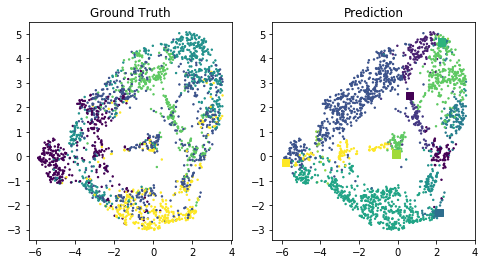

Start of epoch 91
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 323.1528 - loss_neg_E_pz: 45.4164 - loss_E_qzx   : 0.7314
 Training loss over epoch: 374.2124328613281
 326.219238,  47.637714,  0.355504,  0.743012
Start of epoch 92
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 331.5314 - loss_neg_E_pz: 47.9596 - loss_E_qzx   : -0.0928
 Training loss over epoch: 373.5697937011719
 325.802368,  47.431065,  0.336291,  0.740706
Start of epoch 93
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 315.9211 - loss_neg_E_pz: 46.9889 - loss_E_qzx   : 0.2424
 Training loss over epoch: 373.5737609863281
 325.971313,  47.370560,  0.231922,  0.739487
Start of epoch 94
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 328.1122 - loss_neg_E_pz: 46.4119 - loss_E_qzx   : 0.2380
 Training loss over epoch: 372.6775817871094
 325.504395,  47.080547,  0.092607,  0.740548
Start of epoch 95
70/70 [==================

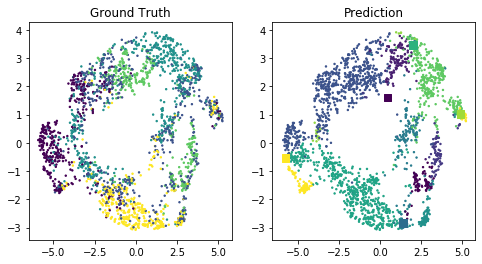

Start of epoch 101
70/70 [==============================] - 8s 115ms/step - loss_neg_E_nb: 333.5525 - loss_neg_E_pz: 43.8127 - loss_E_qzx   : 0.4721
 Training loss over epoch: 370.66387939453125
 324.463959,  46.217419, -0.017581,  0.739346
Start of epoch 102
70/70 [==============================] - 8s 116ms/step - loss_neg_E_nb: 323.1839 - loss_neg_E_pz: 47.3460 - loss_E_qzx   : 0.8296
 Training loss over epoch: 369.6006164550781
 323.294281,  46.242554,  0.063859,  0.737141
Start of epoch 103
70/70 [==============================] - 8s 116ms/step - loss_neg_E_nb: 323.4724 - loss_neg_E_pz: 45.5836 - loss_E_qzx   : -0.2326
 Training loss over epoch: 368.97821044921875
 323.292969,  45.962193, -0.276948,  0.737281
Start of epoch 104
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 318.5842 - loss_neg_E_pz: 46.0778 - loss_E_qzx   : -0.6175
 Training loss over epoch: 368.7281494140625
 323.056885,  45.892727, -0.221360,  0.738352
Start of epoch 105
70/70 [==========

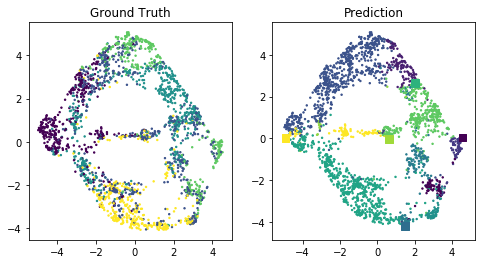

Start of epoch 111
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 326.5831 - loss_neg_E_pz: 45.8559 - loss_E_qzx   : 0.5598
 Training loss over epoch: 366.2438659667969
 321.266266,  45.227692, -0.250141,  0.734216
Start of epoch 112
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 332.0061 - loss_neg_E_pz: 45.7820 - loss_E_qzx   : -0.4594
 Training loss over epoch: 365.7722473144531
 321.014069,  45.172871, -0.414660,  0.733345
Start of epoch 113
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 315.7790 - loss_neg_E_pz: 44.6362 - loss_E_qzx   : -0.1922
 Training loss over epoch: 365.0909729003906
 320.560669,  44.890442, -0.360075,  0.734136
Start of epoch 114
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 329.8989 - loss_neg_E_pz: 44.3591 - loss_E_qzx   : 0.0013
 Training loss over epoch: 365.2917785644531
 320.813965,  44.782497, -0.304608,  0.732828
Start of epoch 115
70/70 [============

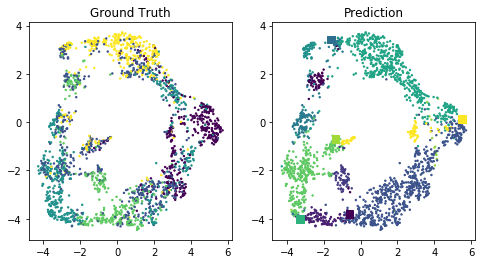

Start of epoch 121
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 304.7327 - loss_neg_E_pz: 43.1044 - loss_E_qzx   : -0.7987
 Training loss over epoch: 363.0993347167969
 319.059723,  44.279400, -0.239738,  0.729170
Start of epoch 122
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 315.3584 - loss_neg_E_pz: 43.8213 - loss_E_qzx   : 0.0701
 Training loss over epoch: 362.5754089355469
 318.769836,  44.048004, -0.242372,  0.728079
Start of epoch 123
70/70 [==============================] - 8s 118ms/step - loss_neg_E_nb: 311.2341 - loss_neg_E_pz: 43.8541 - loss_E_qzx   : -0.5223
 Training loss over epoch: 361.64080810546875
 318.048553,  44.062416, -0.470213,  0.726338
Start of epoch 124
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 340.7886 - loss_neg_E_pz: 44.2560 - loss_E_qzx   : -0.5081
 Training loss over epoch: 362.1241149902344
 318.414734,  43.869972, -0.160549,  0.729064
Start of epoch 125
70/70 [==========

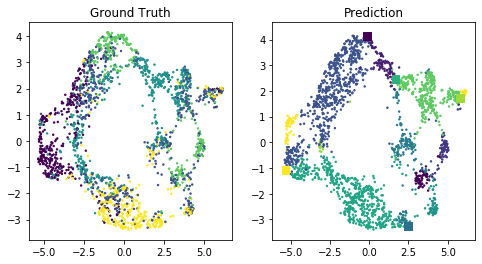

Start of epoch 131
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 320.1778 - loss_neg_E_pz: 43.7644 - loss_E_qzx   : -0.5495
 Training loss over epoch: 360.01763916015625
 317.055634,  43.365101, -0.403164,  0.727531
Start of epoch 132
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 312.9587 - loss_neg_E_pz: 42.7756 - loss_E_qzx   : -0.8217
 Training loss over epoch: 359.6248474121094
 316.802246,  43.315777, -0.493159,  0.724607
Start of epoch 133
70/70 [==============================] - 8s 117ms/step - loss_neg_E_nb: 306.2620 - loss_neg_E_pz: 43.3662 - loss_E_qzx   : -0.8782
 Training loss over epoch: 359.9490051269531
 317.153992,  43.162849, -0.367816,  0.725287
Start of epoch 134
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 312.4992 - loss_neg_E_pz: 44.2016 - loss_E_qzx   : 0.2206
 Training loss over epoch: 359.7447814941406
 316.879700,  43.077366, -0.212332,  0.726366
Start of epoch 135
70/70 [==========

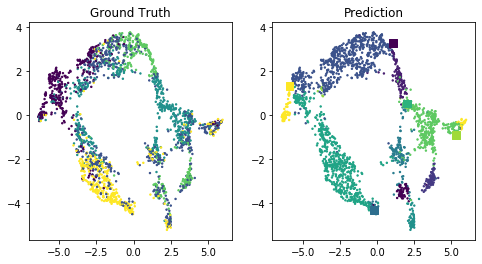

Start of epoch 141
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 319.5527 - loss_neg_E_pz: 43.8348 - loss_E_qzx   : 0.4473
 Training loss over epoch: 357.8868713378906
 315.475433,  42.620445, -0.208984,  0.722013
Start of epoch 142
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 335.9745 - loss_neg_E_pz: 42.2858 - loss_E_qzx   : 0.3981
 Training loss over epoch: 358.3553771972656
 315.857422,  42.501259, -0.003332,  0.721726
Start of epoch 143
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 334.0899 - loss_neg_E_pz: 44.0581 - loss_E_qzx   : 0.3614
 Training loss over epoch: 357.2331237792969
 314.731506,  42.572361, -0.070784,  0.720863
Start of epoch 144
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 321.0670 - loss_neg_E_pz: 41.5671 - loss_E_qzx   : -0.0360
 Training loss over epoch: 356.73834228515625
 314.663177,  42.369995, -0.294740,  0.718947
Start of epoch 145
70/70 [============

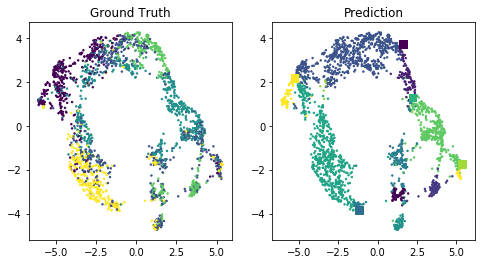

Start of epoch 151
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 311.8954 - loss_neg_E_pz: 42.1977 - loss_E_qzx   : -0.8350
 Training loss over epoch: 355.7319030761719
 313.717407,  41.967041,  0.047379,  0.717787
Start of epoch 152
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 307.2758 - loss_neg_E_pz: 41.7379 - loss_E_qzx   : -0.2143
 Training loss over epoch: 355.7825012207031
 314.059448,  41.894413, -0.171224,  0.717322
Start of epoch 153
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 293.6339 - loss_neg_E_pz: 41.0137 - loss_E_qzx   : -0.1111
 Training loss over epoch: 354.9908447265625
 313.403320,  41.916733, -0.329295,  0.716541
Start of epoch 154
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 336.4992 - loss_neg_E_pz: 42.8581 - loss_E_qzx   : 0.4698
 Training loss over epoch: 355.29681396484375
 313.406952,  41.868942,  0.020878,  0.715264
Start of epoch 155
70/70 [==========

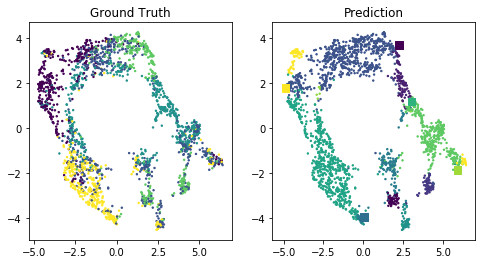

Start of epoch 161
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 331.6773 - loss_neg_E_pz: 40.0005 - loss_E_qzx   : 0.4349
 Training loss over epoch: 353.78887939453125
 312.088043,  41.438473,  0.262395,  0.713278
Start of epoch 162
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 303.6284 - loss_neg_E_pz: 40.5626 - loss_E_qzx   : -0.1619
 Training loss over epoch: 353.1866760253906
 311.924683,  41.319912, -0.058035,  0.713348
Start of epoch 163
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 306.9614 - loss_neg_E_pz: 41.8897 - loss_E_qzx   : -0.2518
 Training loss over epoch: 353.1214904785156
 311.596802,  41.348087,  0.176578,  0.711776
Start of epoch 164
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 304.4239 - loss_neg_E_pz: 41.9759 - loss_E_qzx   : -0.3532
 Training loss over epoch: 353.2283630371094
 311.862457,  41.177273,  0.188600,  0.713396
Start of epoch 165
70/70 [==========

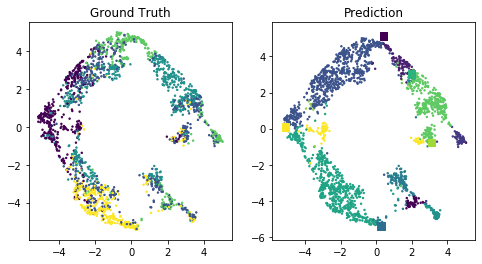

Start of epoch 171
70/70 [==============================] - 8s 115ms/step - loss_neg_E_nb: 283.9812 - loss_neg_E_pz: 41.7202 - loss_E_qzx   : 0.0798
 Training loss over epoch: 352.2215270996094
 310.915375,  40.876236,  0.429888,  0.708429
Start of epoch 172
70/70 [==============================] - 8s 115ms/step - loss_neg_E_nb: 313.5890 - loss_neg_E_pz: 39.5287 - loss_E_qzx   : 0.0671
 Training loss over epoch: 351.8477783203125
 310.886230,  40.743671,  0.217846,  0.708934
Start of epoch 173
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 295.8940 - loss_neg_E_pz: 39.9198 - loss_E_qzx   : 0.3516
 Training loss over epoch: 351.94610595703125
 310.678131,  40.780704,  0.487326,  0.707748
Start of epoch 174
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 315.7371 - loss_neg_E_pz: 40.7603 - loss_E_qzx   : 0.5025
 Training loss over epoch: 351.76629638671875
 310.682831,  40.769402,  0.314009,  0.710399
Start of epoch 175
70/70 [============

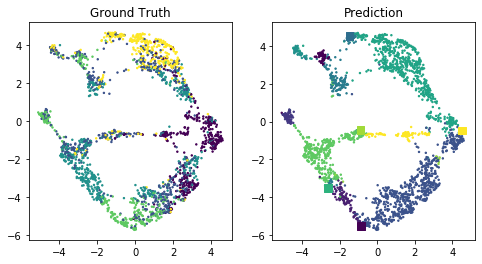

Start of epoch 181
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 308.5908 - loss_neg_E_pz: 40.4788 - loss_E_qzx   : 0.1961
 Training loss over epoch: 350.41455078125
 309.586945,  40.425835,  0.401771,  0.704347
Start of epoch 182
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 307.1704 - loss_neg_E_pz: 39.8329 - loss_E_qzx   : 0.4844
 Training loss over epoch: 350.81048583984375
 309.812012,  40.394871,  0.603632,  0.704323
Start of epoch 183
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 295.8236 - loss_neg_E_pz: 38.7527 - loss_E_qzx   : 0.5879
 Training loss over epoch: 350.36181640625
 309.417725,  40.340824,  0.603203,  0.706922
Start of epoch 184
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 316.6302 - loss_neg_E_pz: 39.7592 - loss_E_qzx   : 0.8394
 Training loss over epoch: 350.1297302246094
 309.092468,  40.318874,  0.718340,  0.703898
Start of epoch 185
70/70 [=================

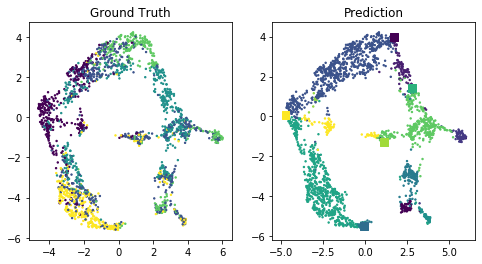

Start of epoch 191
70/70 [==============================] - 8s 115ms/step - loss_neg_E_nb: 304.2993 - loss_neg_E_pz: 39.4250 - loss_E_qzx   : 0.2035
 Training loss over epoch: 349.3627624511719
 308.760803,  40.022739,  0.579277,  0.700043
Start of epoch 192
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 315.3132 - loss_neg_E_pz: 40.2703 - loss_E_qzx   : 0.3043
 Training loss over epoch: 349.46673583984375
 308.726776,  39.987225,  0.752623,  0.700085
Start of epoch 193
70/70 [==============================] - 8s 117ms/step - loss_neg_E_nb: 326.7245 - loss_neg_E_pz: 40.4704 - loss_E_qzx   : 1.5083
 Training loss over epoch: 349.1211242675781
 308.477295,  39.864304,  0.779639,  0.699282
Start of epoch 194
70/70 [==============================] - 8s 118ms/step - loss_neg_E_nb: 328.7122 - loss_neg_E_pz: 40.3518 - loss_E_qzx   : 1.0400
 Training loss over epoch: 348.73779296875
 308.100220,  39.856102,  0.781436,  0.700459
Start of epoch 195
70/70 [===============

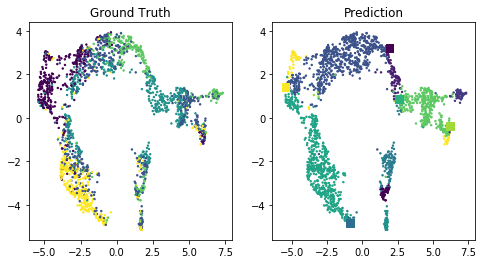

Start of epoch 201
70/70 [==============================] - 8s 108ms/step - loss_neg_E_nb: 294.3062 - loss_neg_E_pz: 39.3656 - loss_E_qzx   : 0.8874
 Training loss over epoch: 347.7806091308594
 307.487488,  39.534657,  0.758600,  0.696393
Start of epoch 202
70/70 [==============================] - 8s 108ms/step - loss_neg_E_nb: 298.6188 - loss_neg_E_pz: 40.6521 - loss_E_qzx   : 0.9885
 Training loss over epoch: 347.687255859375
 307.350677,  39.561134,  0.775468,  0.697172
Start of epoch 203
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 289.1334 - loss_neg_E_pz: 40.1789 - loss_E_qzx   : 0.8957
 Training loss over epoch: 347.8568115234375
 307.439392,  39.459206,  0.958169,  0.694324
Start of epoch 204
70/70 [==============================] - 8s 119ms/step - loss_neg_E_nb: 325.3981 - loss_neg_E_pz: 39.8881 - loss_E_qzx   : 1.5050
 Training loss over epoch: 348.3638916015625
 307.778992,  39.491692,  1.093158,  0.695681
Start of epoch 205
70/70 [===============

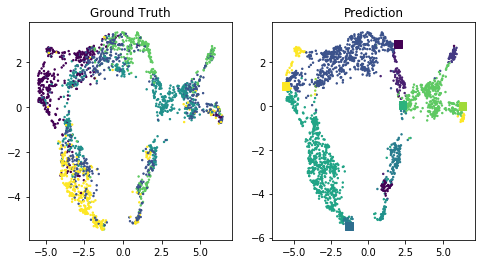

Start of epoch 211
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 291.9545 - loss_neg_E_pz: 39.1161 - loss_E_qzx   : 1.1381
 Training loss over epoch: 346.4506530761719
 306.143250,  39.113319,  1.194121,  0.690148
Start of epoch 212
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 326.3946 - loss_neg_E_pz: 39.6335 - loss_E_qzx   : 1.6107
 Training loss over epoch: 346.4587707519531
 306.178375,  39.132343,  1.148107,  0.691829
Start of epoch 213
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 327.1739 - loss_neg_E_pz: 39.3007 - loss_E_qzx   : 1.2900
 Training loss over epoch: 346.85736083984375
 306.555267,  39.067207,  1.234904,  0.688289
Start of epoch 214
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 303.9158 - loss_neg_E_pz: 39.3490 - loss_E_qzx   : 1.4385
 Training loss over epoch: 346.7745056152344
 306.319183,  39.057007,  1.398282,  0.688438
Start of epoch 215
70/70 [=============

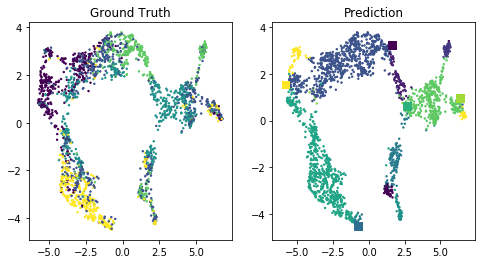

Start of epoch 221
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 317.7164 - loss_neg_E_pz: 38.2414 - loss_E_qzx   : 1.5134
 Training loss over epoch: 345.3460693359375
 305.138367,  38.823536,  1.384119,  0.687191
Start of epoch 222
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 308.6093 - loss_neg_E_pz: 38.9001 - loss_E_qzx   : 1.2811
 Training loss over epoch: 345.4735107421875
 305.543274,  38.795574,  1.134721,  0.685534
Start of epoch 223
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 322.6851 - loss_neg_E_pz: 39.6526 - loss_E_qzx   : 1.8800
 Training loss over epoch: 346.1534729003906
 305.981750,  38.771225,  1.400466,  0.686700
Start of epoch 224
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 317.4664 - loss_neg_E_pz: 39.4484 - loss_E_qzx   : 1.5097
 Training loss over epoch: 345.16851806640625
 305.231293,  38.647957,  1.289246,  0.685507
Start of epoch 225
70/70 [=============

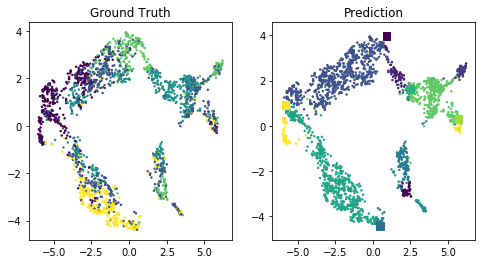

Start of epoch 231
70/70 [==============================] - 8s 114ms/step - loss_neg_E_nb: 312.9615 - loss_neg_E_pz: 38.3510 - loss_E_qzx   : 1.6841
 Training loss over epoch: 344.68994140625
 304.792908,  38.424347,  1.472643,  0.682238
Start of epoch 232
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 284.2132 - loss_neg_E_pz: 37.7188 - loss_E_qzx   : 1.2548
 Training loss over epoch: 344.182861328125
 304.352844,  38.474129,  1.355937,  0.682611
Start of epoch 233
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 320.3998 - loss_neg_E_pz: 37.9187 - loss_E_qzx   : 2.1776
 Training loss over epoch: 344.7740173339844
 304.689575,  38.466431,  1.618001,  0.680969
Start of epoch 234
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 311.1806 - loss_neg_E_pz: 37.0174 - loss_E_qzx   : 1.2914
 Training loss over epoch: 344.4342346191406
 304.547089,  38.362759,  1.524278,  0.681680
Start of epoch 235
70/70 [=================

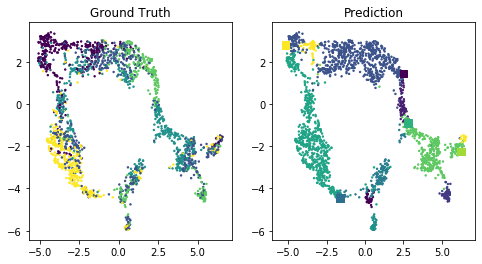

Start of epoch 241
70/70 [==============================] - 8s 114ms/step - loss_neg_E_nb: 295.3713 - loss_neg_E_pz: 38.2538 - loss_E_qzx   : 1.6054
 Training loss over epoch: 343.49053955078125
 303.659851,  38.162170,  1.668587,  0.679692
Start of epoch 242
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 299.6007 - loss_neg_E_pz: 37.4293 - loss_E_qzx   : 1.7874
 Training loss over epoch: 343.35003662109375
 303.487793,  38.122253,  1.740036,  0.678102
Start of epoch 243
70/70 [==============================] - 8s 108ms/step - loss_neg_E_nb: 303.6349 - loss_neg_E_pz: 37.4325 - loss_E_qzx   : 2.0790
 Training loss over epoch: 343.6946105957031
 303.817261,  38.098145,  1.779274,  0.679226
Start of epoch 244
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 311.5980 - loss_neg_E_pz: 38.2096 - loss_E_qzx   : 2.2963
 Training loss over epoch: 343.90362548828125
 303.890381,  38.091171,  1.922141,  0.677150
Start of epoch 245
70/70 [===========

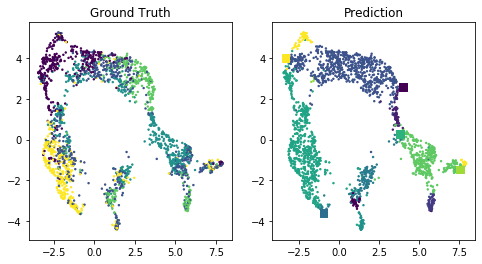

Start of epoch 251
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 310.6816 - loss_neg_E_pz: 37.4201 - loss_E_qzx   : 2.4593
 Training loss over epoch: 343.0736999511719
 303.245605,  37.767914,  2.060199,  0.675529
Start of epoch 252
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 309.5724 - loss_neg_E_pz: 37.3103 - loss_E_qzx   : 2.3915
 Training loss over epoch: 342.7511291503906
 303.060638,  37.775776,  1.914685,  0.673271
Start of epoch 253
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 312.3800 - loss_neg_E_pz: 38.7272 - loss_E_qzx   : 2.1594
 Training loss over epoch: 342.7444152832031
 302.859497,  37.723846,  2.161118,  0.673336
Start of epoch 254
70/70 [==============================] - 8s 111ms/step - loss_neg_E_nb: 287.9485 - loss_neg_E_pz: 36.6164 - loss_E_qzx   : 1.8238
 Training loss over epoch: 342.83831787109375
 302.775299,  37.710957,  2.351932,  0.673404
Start of epoch 255
70/70 [=============

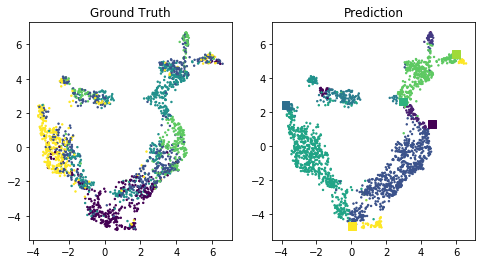

Start of epoch 261
70/70 [==============================] - 8s 115ms/step - loss_neg_E_nb: 309.6696 - loss_neg_E_pz: 37.1418 - loss_E_qzx   : 2.7559
 Training loss over epoch: 341.9886779785156
 302.411102,  37.497295,  2.080246,  0.667323
Start of epoch 262
70/70 [==============================] - 8s 117ms/step - loss_neg_E_nb: 316.4897 - loss_neg_E_pz: 38.2205 - loss_E_qzx   : 2.0421
 Training loss over epoch: 342.7899169921875
 303.125519,  37.392597,  2.271827,  0.668245
Start of epoch 263
70/70 [==============================] - 8s 119ms/step - loss_neg_E_nb: 288.8617 - loss_neg_E_pz: 36.6033 - loss_E_qzx   : 2.3091
 Training loss over epoch: 342.0321044921875
 302.306549,  37.388958,  2.336560,  0.667567
Start of epoch 264
70/70 [==============================] - 8s 120ms/step - loss_neg_E_nb: 295.6115 - loss_neg_E_pz: 36.6284 - loss_E_qzx   : 2.0907
 Training loss over epoch: 341.7496032714844
 302.083862,  37.397976,  2.267709,  0.667611
Start of epoch 265
70/70 [==============

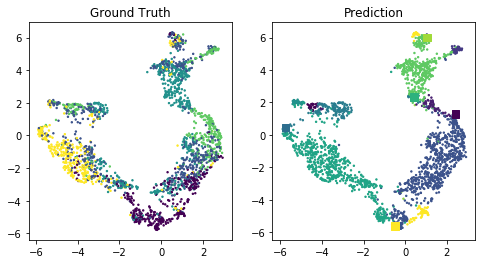

Start of epoch 271
70/70 [==============================] - 8s 113ms/step - loss_neg_E_nb: 306.8518 - loss_neg_E_pz: 36.3016 - loss_E_qzx   : 2.4228
 Training loss over epoch: 341.4024353027344
 301.858154,  37.216068,  2.328248,  0.663484
Start of epoch 272
70/70 [==============================] - 8s 116ms/step - loss_neg_E_nb: 297.3306 - loss_neg_E_pz: 36.8235 - loss_E_qzx   : 2.3726
 Training loss over epoch: 341.2527770996094
 301.698517,  37.160694,  2.393519,  0.663911
Start of epoch 273
70/70 [==============================] - 8s 115ms/step - loss_neg_E_nb: 292.4335 - loss_neg_E_pz: 37.2605 - loss_E_qzx   : 2.6190
 Training loss over epoch: 341.2594299316406
 301.643372,  37.052238,  2.563765,  0.663933
Start of epoch 274
70/70 [==============================] - 8s 114ms/step - loss_neg_E_nb: 321.7489 - loss_neg_E_pz: 36.7758 - loss_E_qzx   : 2.4975
 Training loss over epoch: 340.7156677246094
 301.100891,  36.997784,  2.617037,  0.659516
Start of epoch 275
70/70 [==============

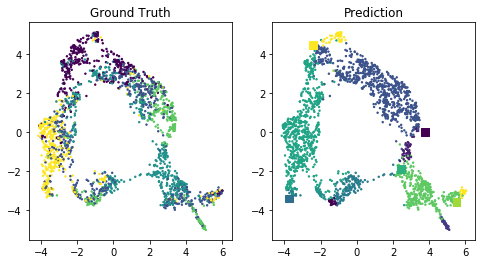

Start of epoch 281
70/70 [==============================] - 8s 112ms/step - loss_neg_E_nb: 309.8127 - loss_neg_E_pz: 36.0936 - loss_E_qzx   : 2.4273
 Training loss over epoch: 340.4272766113281
 301.050507,  36.798386,  2.578398,  0.655370
Start of epoch 282
70/70 [==============================] - 8s 114ms/step - loss_neg_E_nb: 295.9185 - loss_neg_E_pz: 37.1172 - loss_E_qzx   : 2.8146
 Training loss over epoch: 340.5767822265625
 301.135071,  36.842022,  2.599699,  0.658187
Start of epoch 283
70/70 [==============================] - 8s 109ms/step - loss_neg_E_nb: 305.3329 - loss_neg_E_pz: 36.7898 - loss_E_qzx   : 2.3627
 Training loss over epoch: 340.6116638183594
 301.216736,  36.742161,  2.652701,  0.653360
Start of epoch 284
70/70 [==============================] - 8s 110ms/step - loss_neg_E_nb: 308.0049 - loss_neg_E_pz: 36.6700 - loss_E_qzx   : 2.6224
 Training loss over epoch: 340.4244079589844
 301.085724,  36.716450,  2.622226,  0.654572
Start of epoch 285
70/70 [==============

In [0]:
# ---------------------------------------------------------------------------- #
# Training together.
# ---------------------------------------------------------------------------- #
optimizer = tf.keras.optimizers.Adam(1e-4)
optimizer_cluster = tf.keras.optimizers.Adam(1e-4)
loss_total = tf.keras.metrics.Mean()
loss_neg_E_nb = tf.keras.metrics.Mean()
loss_neg_E_pz = tf.keras.metrics.Mean()
loss_E_qzx = tf.keras.metrics.Mean()
loss_cluster = tf.keras.metrics.Mean()
early_stopping = Early_Stopping(patience=10, tolerance=1e-4)
# loss_weights = tf.convert_to_tensor(np.array([0.1,1,1]), tf.float32)

for epoch in range(NUM_EPOCH):
    print('Start of epoch %d' % (epoch,))
    progbar = Progbar(NUM_STEP_PER_EPOCH)
    
    # Iterate over the batches of the dataset.
    for step, (x_batch, x_norm_batch, x_scale_factor) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            _ = vae(x_norm_batch, x_batch, x_scale_factor)            
            losses = vae.losses
            loss = tf.reduce_sum(vae.losses)
        grads = tape.gradient(loss, vae.trainable_weights,
                              unconnected_gradients=tf.UnconnectedGradients.ZERO)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))
        #vae.GMM.normalize()
        loss_total(loss)
        loss_neg_E_nb(vae.losses[0])
        loss_neg_E_pz(vae.losses[1])
        loss_E_qzx(vae.losses[2])
                    
        # Clustering      
        # if step%3==0:
        with tf.GradientTape() as tape:
            vae(x_norm_batch, cluster=True)            
            cluster_loss = tf.reduce_sum(vae.losses)  
    
        grads = tape.gradient(cluster_loss, vae.trainable_weights,
                            unconnected_gradients=tf.UnconnectedGradients.ZERO)
        optimizer_cluster.apply_gradients(zip(grads, vae.trainable_weights))
        loss_cluster(cluster_loss)
        
        if (step+1)%20==0 or step+1==NUM_STEP_PER_EPOCH:
            progbar.update(step+1, [
                    ('loss_neg_E_nb'    ,   float(losses[0])),
                    ('loss_neg_E_pz'    ,   float(losses[1])),
                    ('loss_E_qzx   '    ,   float(losses[2])),                    
                    ])

    if early_stopping(float(loss_total.result())):
        print('Early stopping.')
        break
    print(' Training loss over epoch: %s' % (float(loss_total.result())))  
    print('% 4.6f, % 4.6f, % 4.6f, % 4.6f' % (float(loss_neg_E_nb.result()),
                                      float(loss_neg_E_pz.result()),
                                      float(loss_E_qzx.result()),
                                      float(loss_cluster.result())))
    loss_total.reset_states()
    loss_neg_E_nb.reset_states()
    loss_neg_E_pz.reset_states()
    loss_E_qzx.reset_states()
    loss_cluster.reset_states()

    if epoch%10==0 or epoch==NUM_EPOCH-1:        
        pi,mu,c,w,var_w,z,proj_z = vae(X_normalized, inference=True)

        fit = umap.UMAP()
        uz = fit.fit_transform(z)
        u = fit.transform(mu.numpy().T)

        plt.figure(figsize=(8,4))
        ax = plt.subplot(121)
        plt.scatter(uz[:,0], uz[:,1], c=y, s=2)
        ax.set_title('Ground Truth')

        ax = plt.subplot(122)
        scatter = plt.scatter(uz[:,0], uz[:,1], c=c, s=2)
        ax.set_title('Prediction')        
        # legend1 = ax.legend(*scatter.legend_elements(),
        #                     loc="lower left", title="Classes")
        # ax.add_artist(legend1)
        cluster_center = [(NUM_CLUSTER+(1-i)/2)*i for i in range(NUM_CLUSTER)]        
        plt.scatter(u[:,0], u[:,1], c=cluster_center, s=60, marker='s')
        plt.savefig('/content/drive/My Drive/Data/%d.png'%epoch, dpi=300)
        plt.show()
        vae.save_weights('/content/drive/My Drive/Data/train.checkpoint')

In [0]:
A,B=np.nonzero(np.triu(np.ones(NUM_CLUSTER)))
print(A)
print(B)

[0 0 0 0 0 1 1 1 1 2 2 2 3 3 4]
[0 1 2 3 4 1 2 3 4 2 3 4 3 4 4]


# Evaulation

In [0]:
vae.save_weights('/content/drive/My Drive/Data/train_distinct_3.checkpoint')
# vae.load_weights('tf.checkpoint')
# !mv train.checkpoint.data-00000-of-00001 /content/drive/My\ Drive/Data/

In [0]:
pi,mu,c,w,var_w,z,proj_z = vae(X_normalized, inference=True)

In [0]:
var_w

<tf.Tensor: shape=(2221,), dtype=float32, numpy=
array([-0.18536879, -0.24125484, -0.37526223, ..., -0.24037115,
       -0.46539798, -0.22733565], dtype=float32)>

In [0]:
vae.GMM.pi

<tf.Variable 'pi:0' shape=(1, 15) dtype=float32, numpy=
array([[-0.2889328 , -0.53159344,  0.5127043 ,  0.14176892,  0.24890389,
        -0.5610209 , -0.42827165, -0.524663  , -0.06420217,  0.64643055,
         0.5059012 ,  0.07673476,  0.03109856, -0.08543876, -0.03243956]],
      dtype=float32)>

In [0]:
df = pd.value_counts(list(c.numpy()))
cluster_center = [int((NUM_CLUSTER+(1-i)/2)*i) for i in range(NUM_CLUSTER)]  
df[~df.index.isin(cluster_center)]

10    674
1     329
11    290
6     217
8     162
3     148
2     119
13    118
4     114
7      50
dtype: int64

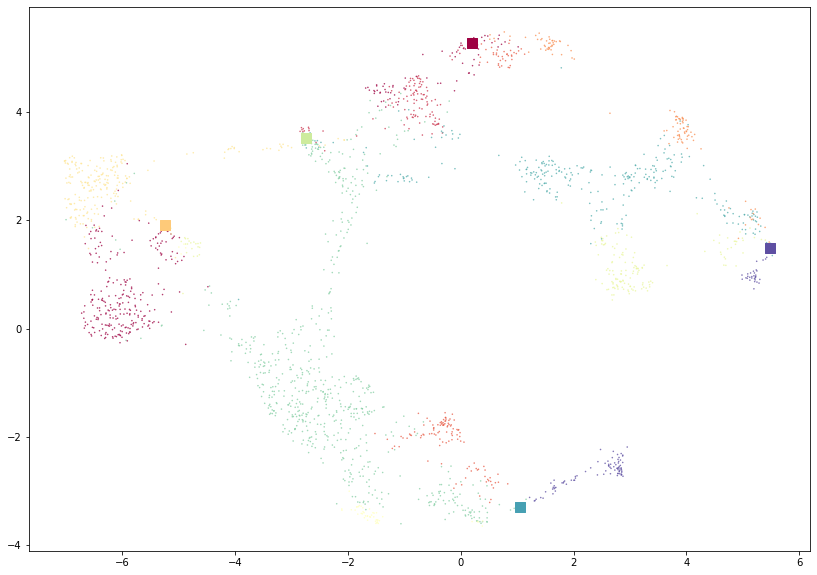

In [0]:
concate_z = np.concatenate((z.numpy(), mu.numpy().T.copy()), axis=0)
mapper = umap.UMAP().fit(concate_z)
cluster_center = [int((NUM_CLUSTER+(1-i)/2)*i) for i in range(NUM_CLUSTER)]  

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*mapper.embedding_[:-NUM_CLUSTER,:].T, s=0.3, c=c.numpy(), cmap='Spectral', alpha=0.8)
plt.scatter(*mapper.embedding_[-NUM_CLUSTER:,:].T, c=cluster_center, cmap='Spectral', s=100, marker='s')
plt.savefig('/content/drive/My Drive/Data/cluster_result.png', dpi=300)

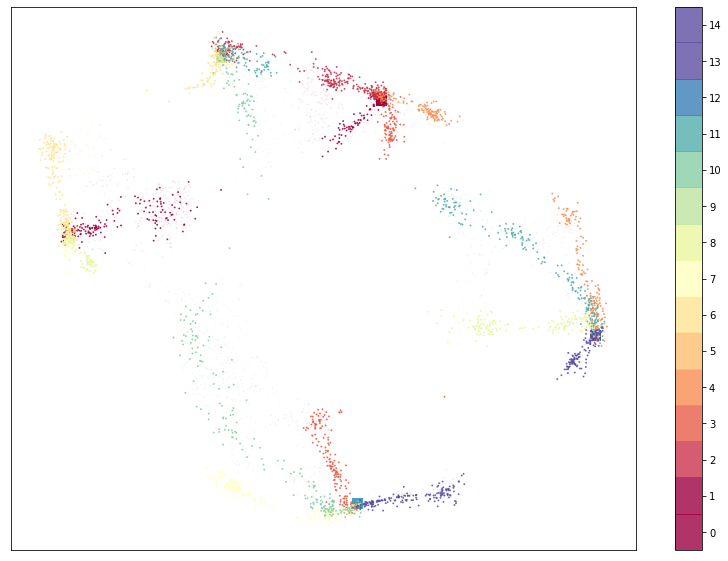

In [0]:
concate_z = np.concatenate((z.numpy(), mu.numpy().T.copy()), axis=0)
mapper = umap.UMAP().fit(concate_z)

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*mapper.embedding_[:-NUM_CLUSTER,:].T, s=0.3, c=c.numpy(), cmap='Spectral', alpha=0.1)
plt.scatter(*mapper.embedding_[-NUM_CLUSTER:,:].T, c=cluster_center, cmap='Spectral', s=100, marker='s')

M = 300
m = z.numpy().shape[0]
cluster_center = [int((NUM_CLUSTER+(1-i)/2)*i) for i in range(NUM_CLUSTER)]  
n_states = int(NUM_CLUSTER*(NUM_CLUSTER+1)/2)
A,B=np.nonzero(np.triu(np.ones(NUM_CLUSTER)))
w = tf.convert_to_tensor(
            np.resize(np.arange(0,M)/M, (1, M)), tf.float32)
proj_c = np.tile([i for i in np.arange(n_states) if i not in cluster_center], (M,1)).T.flatten()
proj_z_M = tf.transpose(
                tf.gather(mu, tf.gather(A, proj_c), axis=1) * 
                tf.tile(w, [1,n_states-NUM_CLUSTER]) + 
                tf.gather(mu, tf.gather(B, proj_c), axis=1) * 
                (1-tf.tile(w, [1,n_states-NUM_CLUSTER])))
test_embedding = mapper.transform(proj_z_M)#proj_z_M.numpy())

plt.scatter(*test_embedding.T, s=0.8, c=proj_c, cmap='Spectral', alpha=0.8)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(n_states+1)-0.5)
cbar.set_ticks(np.arange(n_states))
cbar.set_ticklabels(np.arange(n_states))

KeyError: ignored

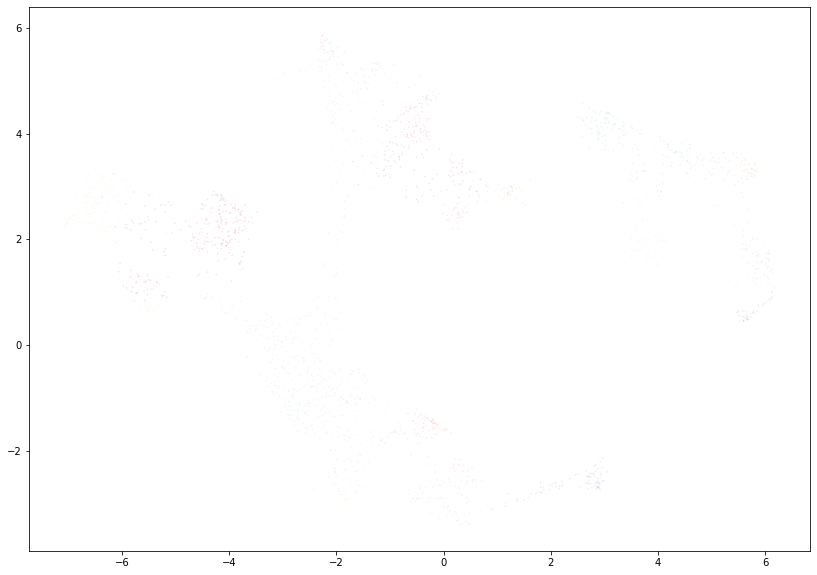

In [0]:
concate_z = np.concatenate((z.numpy(), mu.numpy().T.copy()), axis=0)
mapper = umap.UMAP().fit(concate_z)

embed_mu = mapper.embedding_[-NUM_CLUSTER:,:].copy()
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*mapper.embedding_[:-NUM_CLUSTER,:].T, s=0.3, c=c.numpy(), cmap='Spectral', alpha=0.1)

n_states = int(NUM_CLUSTER*(NUM_CLUSTER+1)/2)
M = 100
m = z.numpy().shape[0]
cluster_center = [int((NUM_CLUSTER+(1-i)/2)*i) for i in range(NUM_CLUSTER)]  
df = pd.value_counts(list(c.numpy()))/len(c)
_df = df[~df.index.isin(cluster_center)].to_frame()
def _score(row):
    i = row.name
    return row / np.min([df[cluster_center[A[i]]], df[cluster_center[B[i]]]])
_df['score'] = _df.apply(_score, axis=1)

edges = list(_df[_df['score'] >0.05].index)
n_edges = len(edges)
if n_edges>0:
    n_states = int(NUM_CLUSTER*(NUM_CLUSTER+1)/2)
    A,B=np.nonzero(np.triu(np.ones(NUM_CLUSTER)))
    w = tf.convert_to_tensor(
                np.resize(np.arange(0,M)/M, (1, M)), tf.float32)
    proj_c = np.tile(edges, (M,1)).T.flatten()
    proj_z_M = tf.transpose(
                    tf.gather(mu, tf.gather(A, proj_c), axis=1) * 
                    tf.tile(w, [1,n_edges]) + 
                    tf.gather(mu, tf.gather(B, proj_c), axis=1) * 
                    (1-tf.tile(w, [1,n_edges])))
    test_embedding = mapper.transform(proj_z_M.numpy())#proj_z_M.numpy())

    plt.scatter(*test_embedding.T, s=0.8, c=proj_c, cmap='Spectral', alpha=0.8)
plt.scatter(*embed_mu.T, c=cluster_center, cmap='Spectral', s=100, marker='s')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(n_states+1)-0.5)
cbar.set_ticks(np.arange(n_states))
cbar.set_ticklabels(np.arange(n_states))
plt.savefig('/content/drive/My Drive/Data/project_points.png', dpi=300)

In [0]:
pd.value_counts(list(c.numpy()))

10    674
1     329
11    290
6     217
8     162
3     148
2     119
13    118
4     114
7      50
dtype: int64

In [0]:
print(A)
print(B)
print(cluster_center)

[0 0 0 0 0 1 1 1 1 2 2 2 3 3 4]
[0 1 2 3 4 1 2 3 4 2 3 4 3 4 4]
[0, 5, 9, 12, 14]


In [0]:
for i in list(df.index):
    print(i)
    print(pi[0,i].numpy(), pi[0,cluster_center[A[i]]].numpy(), pi[0,cluster_center[B[i]]].numpy())
    # print(pi[0,i].numpy()- (pi[0,cluster_center[A[i]]].numpy()+ pi[0,cluster_center[B[i]]].numpy())/2)

10
0.10524671 0.12112663 0.06546427
2
0.10596515 0.047535326 0.12112663
4
0.08139467 0.047535326 0.061434183
3
0.07312533 0.047535326 0.06546427
8
0.059513535 0.0362118 0.061434183
11
0.06852103 0.12112663 0.061434183
13
0.058262996 0.06546427 0.061434183
6
0.041352555 0.0362118 0.12112663
7
0.037552617 0.0362118 0.06546427
1
0.037293255 0.047535326 0.0362118


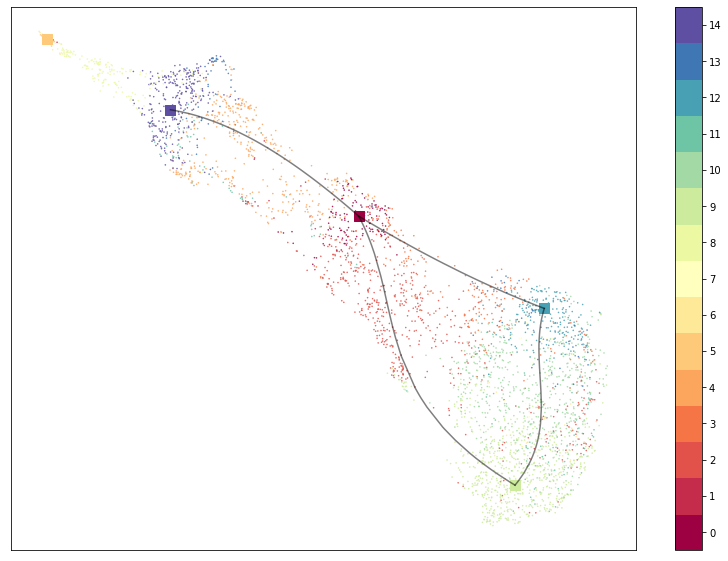

In [0]:
from scipy.interpolate import splrep, splev

A,B=np.nonzero(np.triu(np.ones(NUM_CLUSTER)))
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*mapper.embedding_[:-NUM_CLUSTER,:].T, s=0.3, c=c.numpy(), cmap='Spectral', alpha=0.9)

# plt.scatter(*test_embedding.T, s=0.8, c=proj_c, cmap='Spectral', alpha=0.8)
embed_edges = test_embedding.copy()
for i in np.unique(edges):
    data = np.concatenate((embed_mu[A[i]:A[i]+1,:], embed_edges[proj_c==i,:], embed_mu[B[i]:B[i]+1,:]), axis=0)
    x_range = np.sort([embed_mu[A[i],0], embed_mu[B[i],0]])
    y_range = np.sort([embed_mu[A[i],1], embed_mu[B[i],1]])
    data[data[:,0]<x_range[0],0] = x_range[0]
    data[data[:,0]>x_range[1],0] = x_range[1]
    data[data[:,1]<y_range[0],1] = y_range[0]
    data[data[:,1]>y_range[1],1] = y_range[1]
    # data = data[(data[:,0]>=x_range[0])&(data[:,0]<=x_range[1]),:]
    # data = data[(data[:,1]>=y_range[0])&(data[:,1]<=y_range[1]),:]
    w = np.ones(len(data))*0.01
    w[0] = w[-1] = 1
    
    if data.shape[0]==2:
        pass
        plt.plot(*data.T, color="black", alpha=0.5)
        
    else:

        if np.sum(np.abs(embed_mu[A[i],:]-embed_mu[B[i],:])*[1,-1])<0:
            w = w[np.argsort(data[:,1])]
            data = data[np.argsort(data[:,1]), :]
            x,y = data[:,0], data[:,1]        
            bspl = splrep(y, x, w, s=5)        
            x = splev(y, bspl)
        else:
            w = w[np.argsort(data[:,0])]
            data = data[np.argsort(data[:,0]), :]
            x,y = data[:,0], data[:,1]        
            bspl = splrep(x, y, w, s=5)        
            y = splev(x,bspl)

        # data = data[np.argsort(data[:,1]), :]
        # x,y = data[:,0], data[:,1]
        # # w = np.ones(len(x))*0.01
        # # w[0] = w[-1] = 1
        # bspl = splrep(y, x, s=5)        
        # x = splev(y, bspl)

        # data = np.concatenate((embed_mu[A[i],:][np.newaxis,:], np.concatenate((x[:,np.newaxis], y[:,np.newaxis]), axis=1), embed_mu[B[i],:][np.newaxis,:]), axis=0)
        # data = data[np.argsort(data[:,0]), :]
        # x,y = data[:,0], data[:,1]
        # bspl = splrep(x,y, s=5)        
        # y = splev(x,bspl)
        plt.plot(x, y, color="black", alpha=0.5)

plt.scatter(*embed_mu.T, c=cluster_center, cmap='Spectral', s=100, marker='s')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(n_states+1)-0.5)
cbar.set_ticks(np.arange(n_states))
cbar.set_ticklabels(np.arange(n_states))
plt.savefig('/content/drive/My Drive/Data/trajactory.png', dpi=300)

In [0]:
z = z.numpy()
mu = mu.numpy().T
c = c.numpy()
# Embeding z and mu through umap
concate_z = np.concatenate((z, mu), axis=0)
mapper = umap.UMAP().fit(concate_z)
embed_z = mapper.embedding_[:-NUM_CLUSTER,:].copy()
embed_mu = mapper.embedding_[-NUM_CLUSTER:,:].copy()

# Transform projected edges
cluster_center = [int((NUM_CLUSTER+(1-i)/2)*i) for i in range(NUM_CLUSTER)]  
df = pd.value_counts(list(c))
df = df[~df.index.isin(cluster_center)]
df = df[df>0]

edges = list(df.index)
edges_score = df/z.shape[0]
n_edges = len(edges)

A, B = np.nonzero(np.triu(np.ones(NUM_CLUSTER)))
w = np.tile(np.resize(np.arange(0,100)/100, (100, 1)), (n_edges,1))
proj_c = np.tile(edges, (M,1)).T.flatten()
proj_z_M = mu[A[proj_c],:] * w + mu[B[proj_c],:] * (1-w)
embed_edges = mapper.transform(proj_z_M).copy()

In [0]:
import pickle as pk
with open('/content/drive/My Drive/Data/result.pkl','wb') as f:
    pk.dump([c,proj_c,
             embed_z,embed_mu,embed_edges,
             edges,edges_score.values,
             w, var_w
             ],f)

# Reference Code

- Paper Code, Keras (Theano backend): https://github.com/slim1017/VaDE/blob/master/VaDE.py

- Pytorch: https://github.com/GuHongyang/VaDE-pytorch

- Keras (Tensorflow backend): https://github.com/nskat/Larvae/blob/9adc9e7fc300e043b23063b06c912690ef955e25/VaDE/VaDE_tensorflow.py (refactored/improved pretty much everything)



